In [1]:
import arviz as az
import pymc as pm
import preliz as pz
import numpy as np
import scipy.stats as stats
import pandas as pd
import matplotlib.pyplot as plt
az.style.use("arviz-doc")

# Probabilistic programming
- Simplicity of formulating Bayesian models contrasts with the mathematical/computational difficulty of solving them
- To solve bayesian models, numerical methods are used used that can be considered as *universal inference engines*
- Probabilistic Programming Language:
  - Allows to describe in few lines of code a probabilistic model

## Pymc

In [7]:
np.random.seed(123)
experiments = 4
theta_real = 0.35
data = pz.Binomial(n=1, p=theta_real).rvs(size=experiments)
data

array([1, 0, 0, 0], dtype=int64)

$$\theta \sim Beta(\alpha=1,\beta=1)$$
$$Y = Bin(n=1,p=\theta)$$

In [8]:
with pm.Model() as first_model:
    θ = pm.Beta("θ", alpha=1, beta=1)  # a priori
    y = pm.Bernoulli("y", p=θ, observed=data)  # likelihood
    
## Inference
with first_model:
    idata = pm.sample(1000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [θ]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 23 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics


- First line: NUTS sampler
- Third line: Pymc will run 2 chains in parallel, that is, will generate two distinct samples from the posterior
- Fourth line: Which variable has been assigned to which sampling method
- Number of samples generated
  - 4000: 2 chains, for each, 1000 draws and 1000 for tuning

### Summarizing the posterior
- Dot indicates the mean

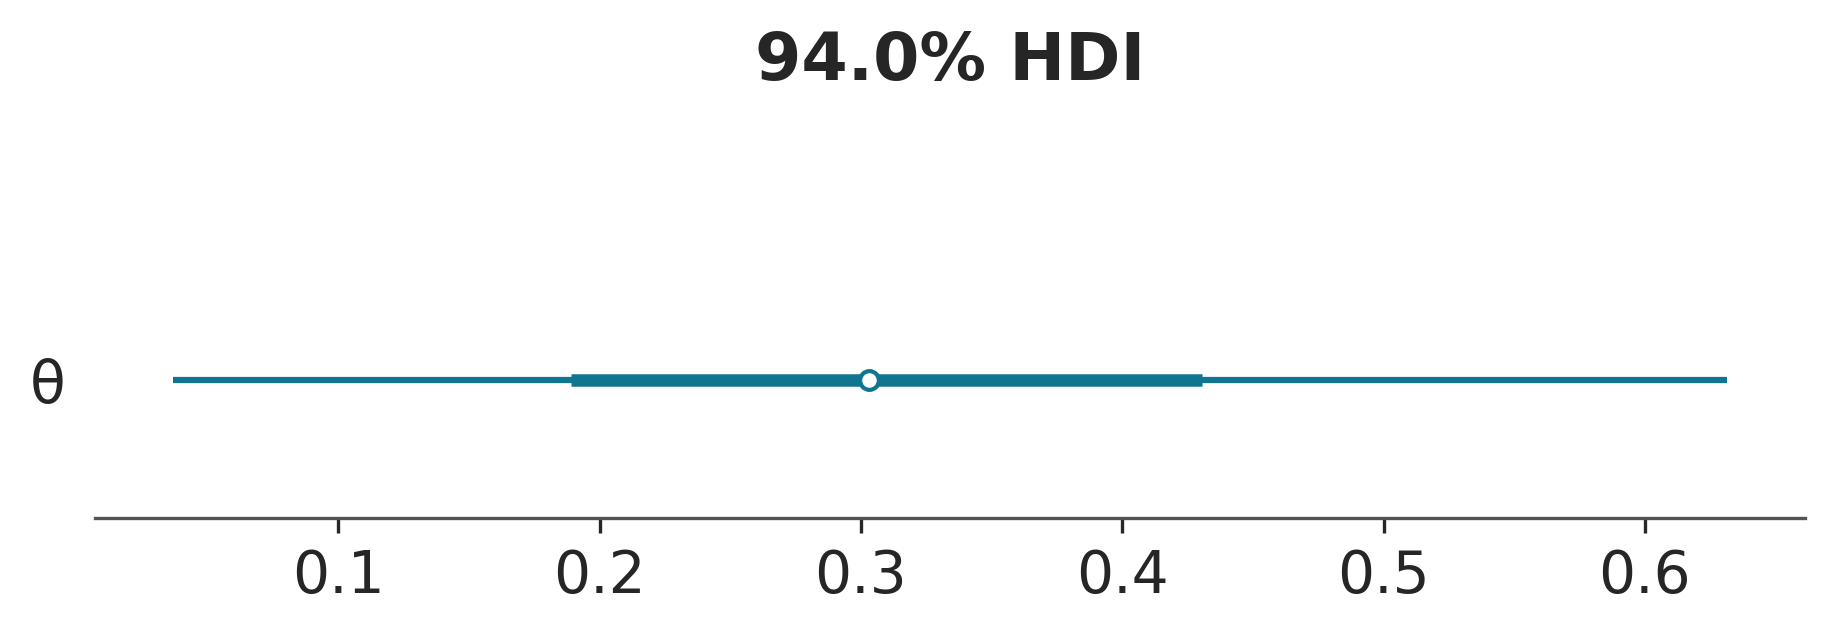

In [9]:
az.plot_forest(idata, combined=True, figsize=(6, 2));

In [10]:
az.summary(idata, kind="stats")

mean     sd  hdi_3%  hdi_97%
θ  0.322  0.171   0.037    0.631

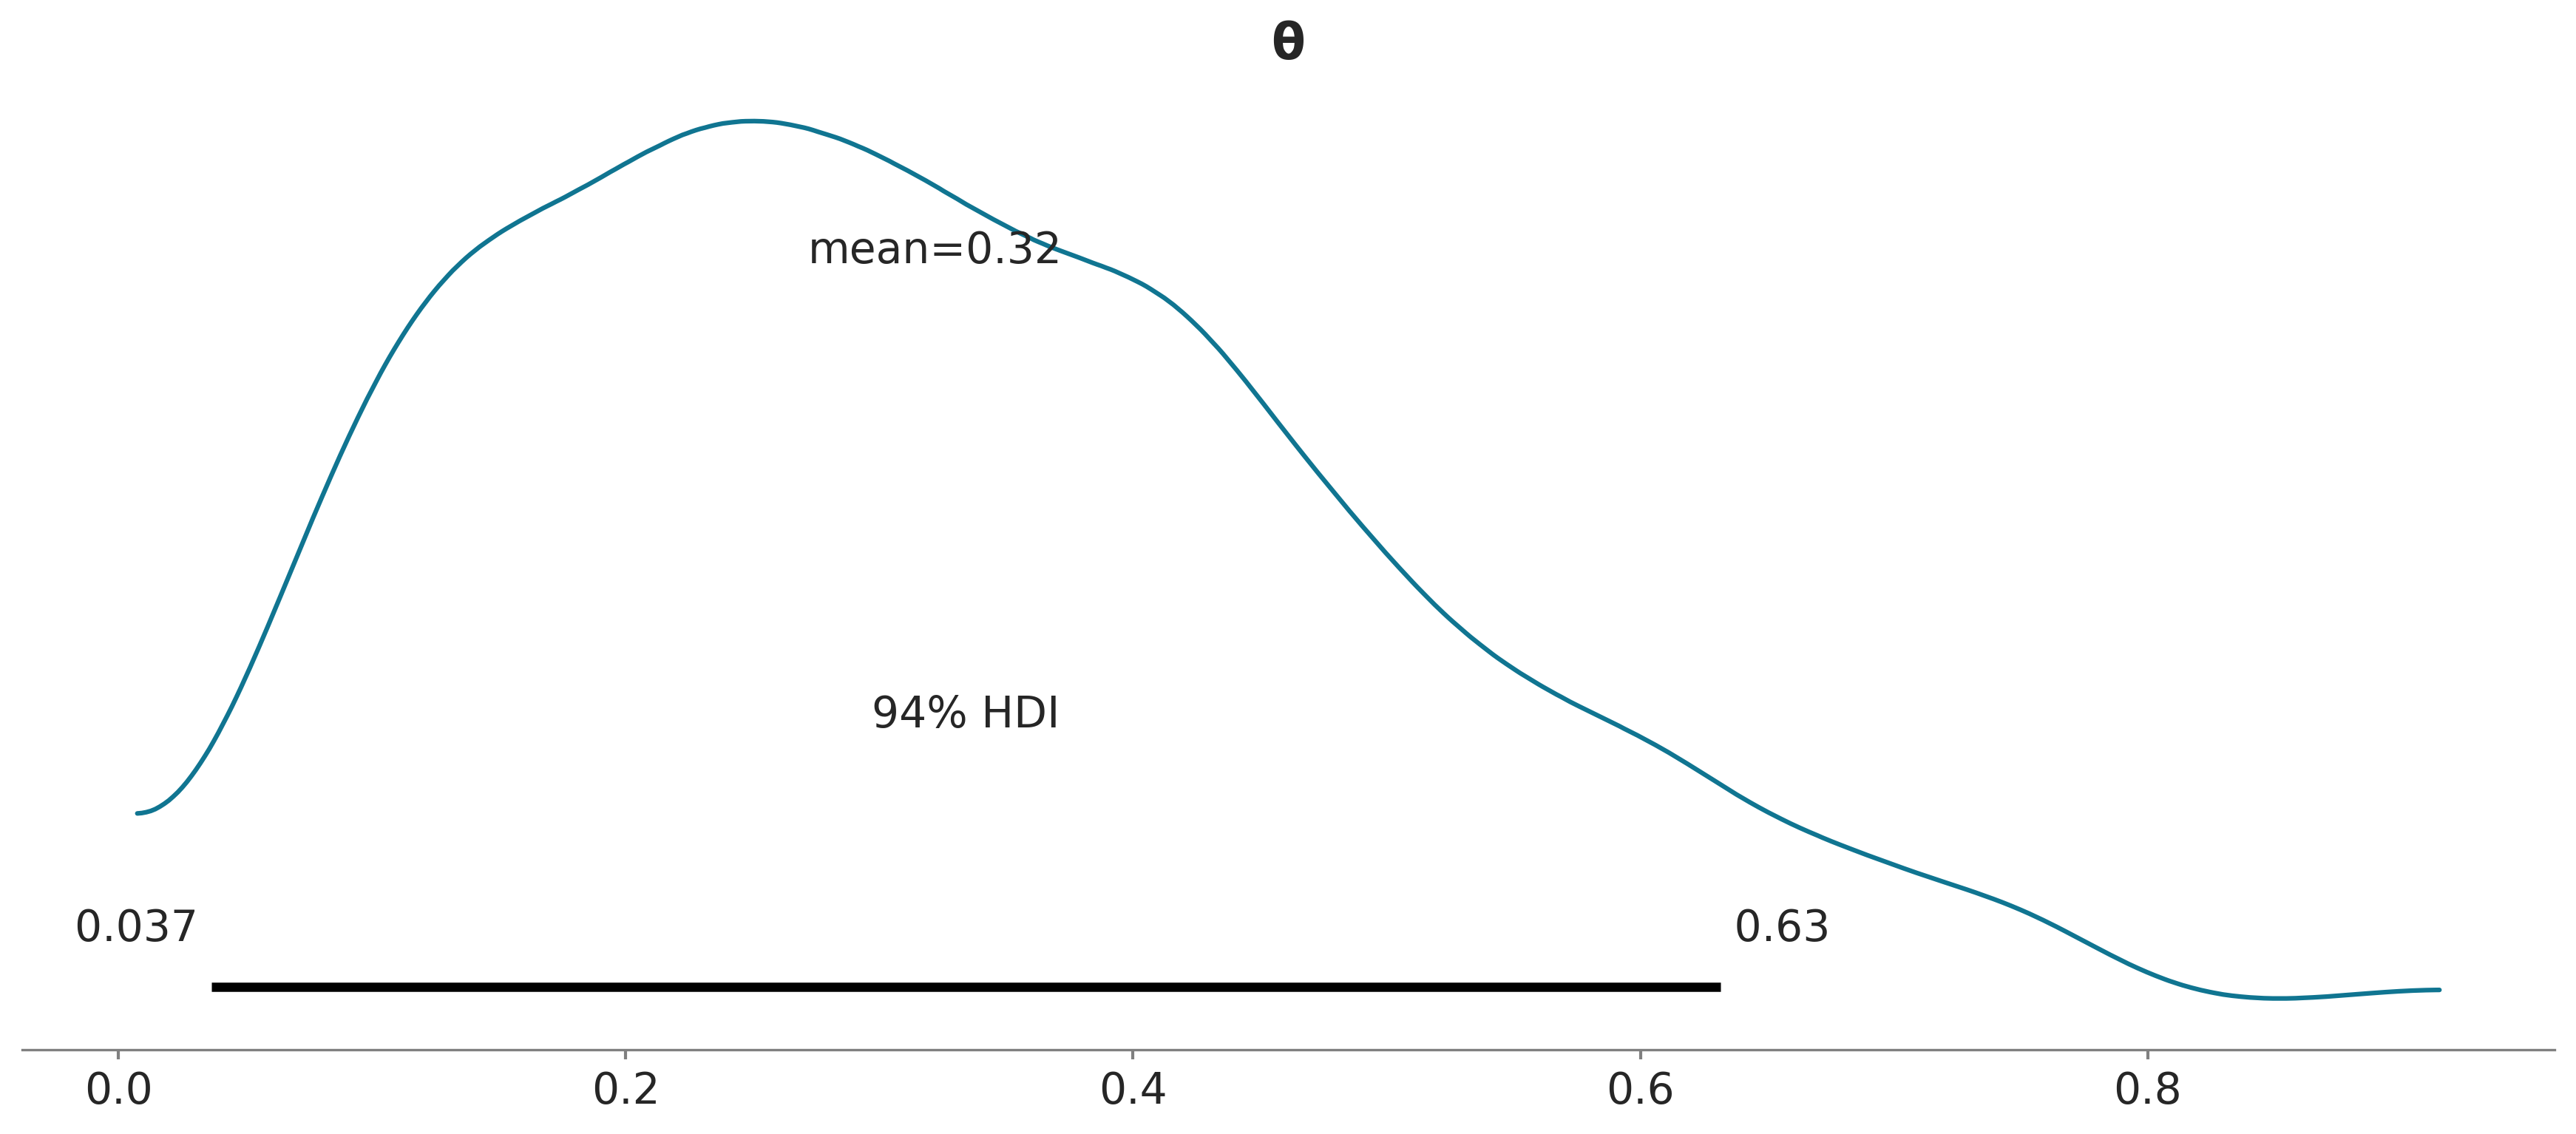

In [11]:
az.plot_posterior(idata);

### Decisions based on the posterior
- ROPE: Region Of Practical Equivalence
  - Observing exactly 0.5 is 0. 
  - Region that is equivalent to a value. $[0.45,0.55]$ is equivalent to being 0.5
  - Following rules to make a decision
    - The value of the parameter is considered unlikely
    - The value of the parameter is accepted if the ROPE completly contains 94% of the parameter in question

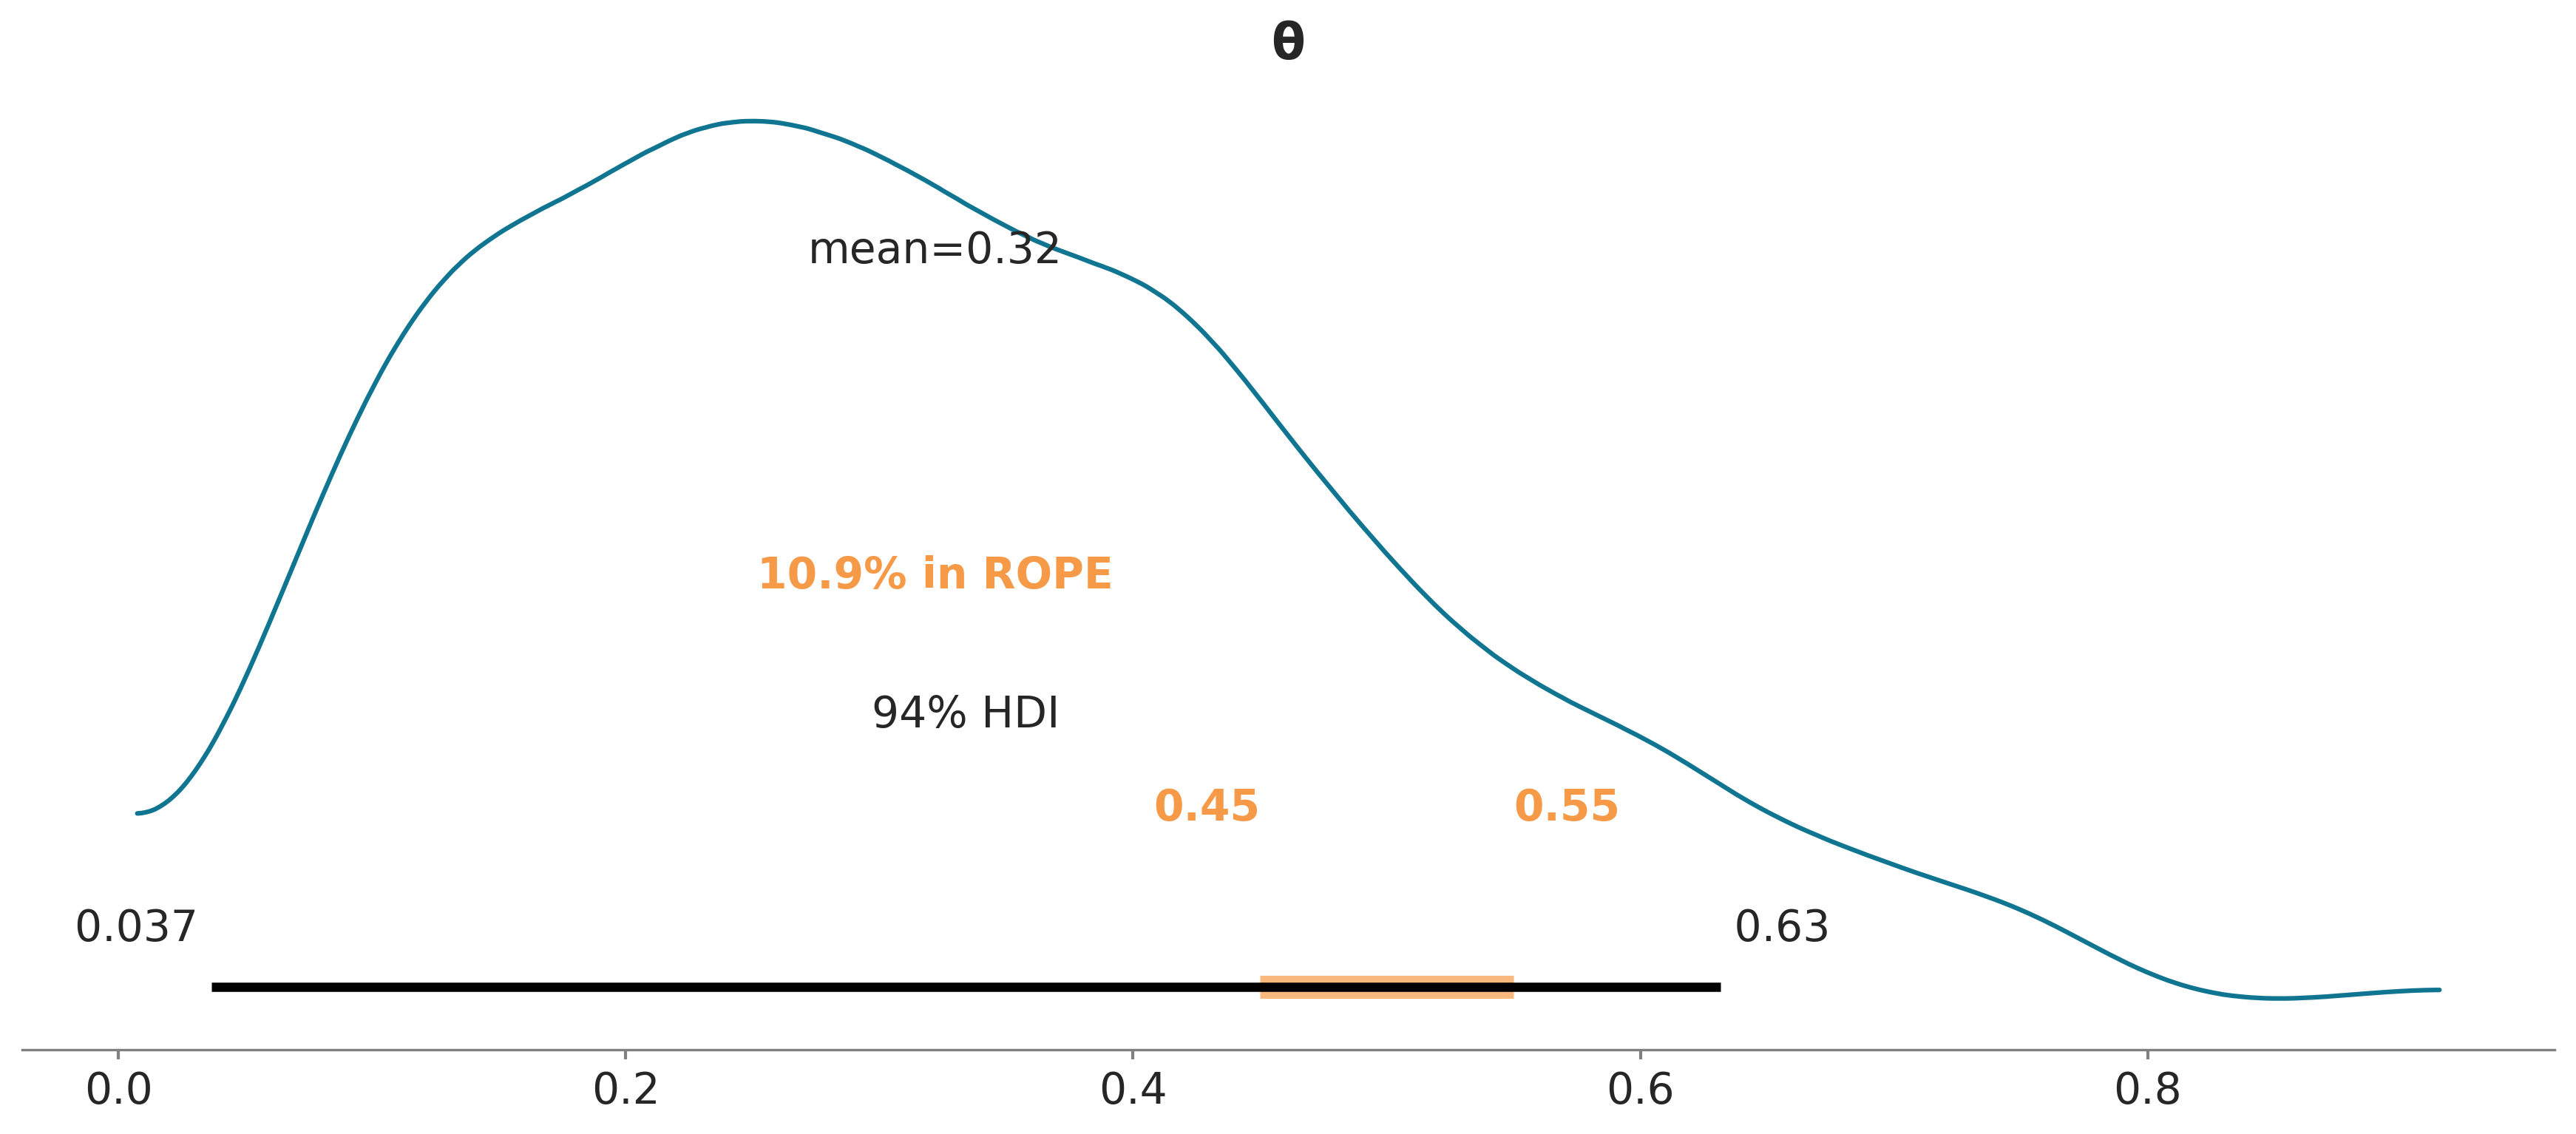

In [12]:
az.plot_posterior(idata, rope=[0.45, 0.55]);

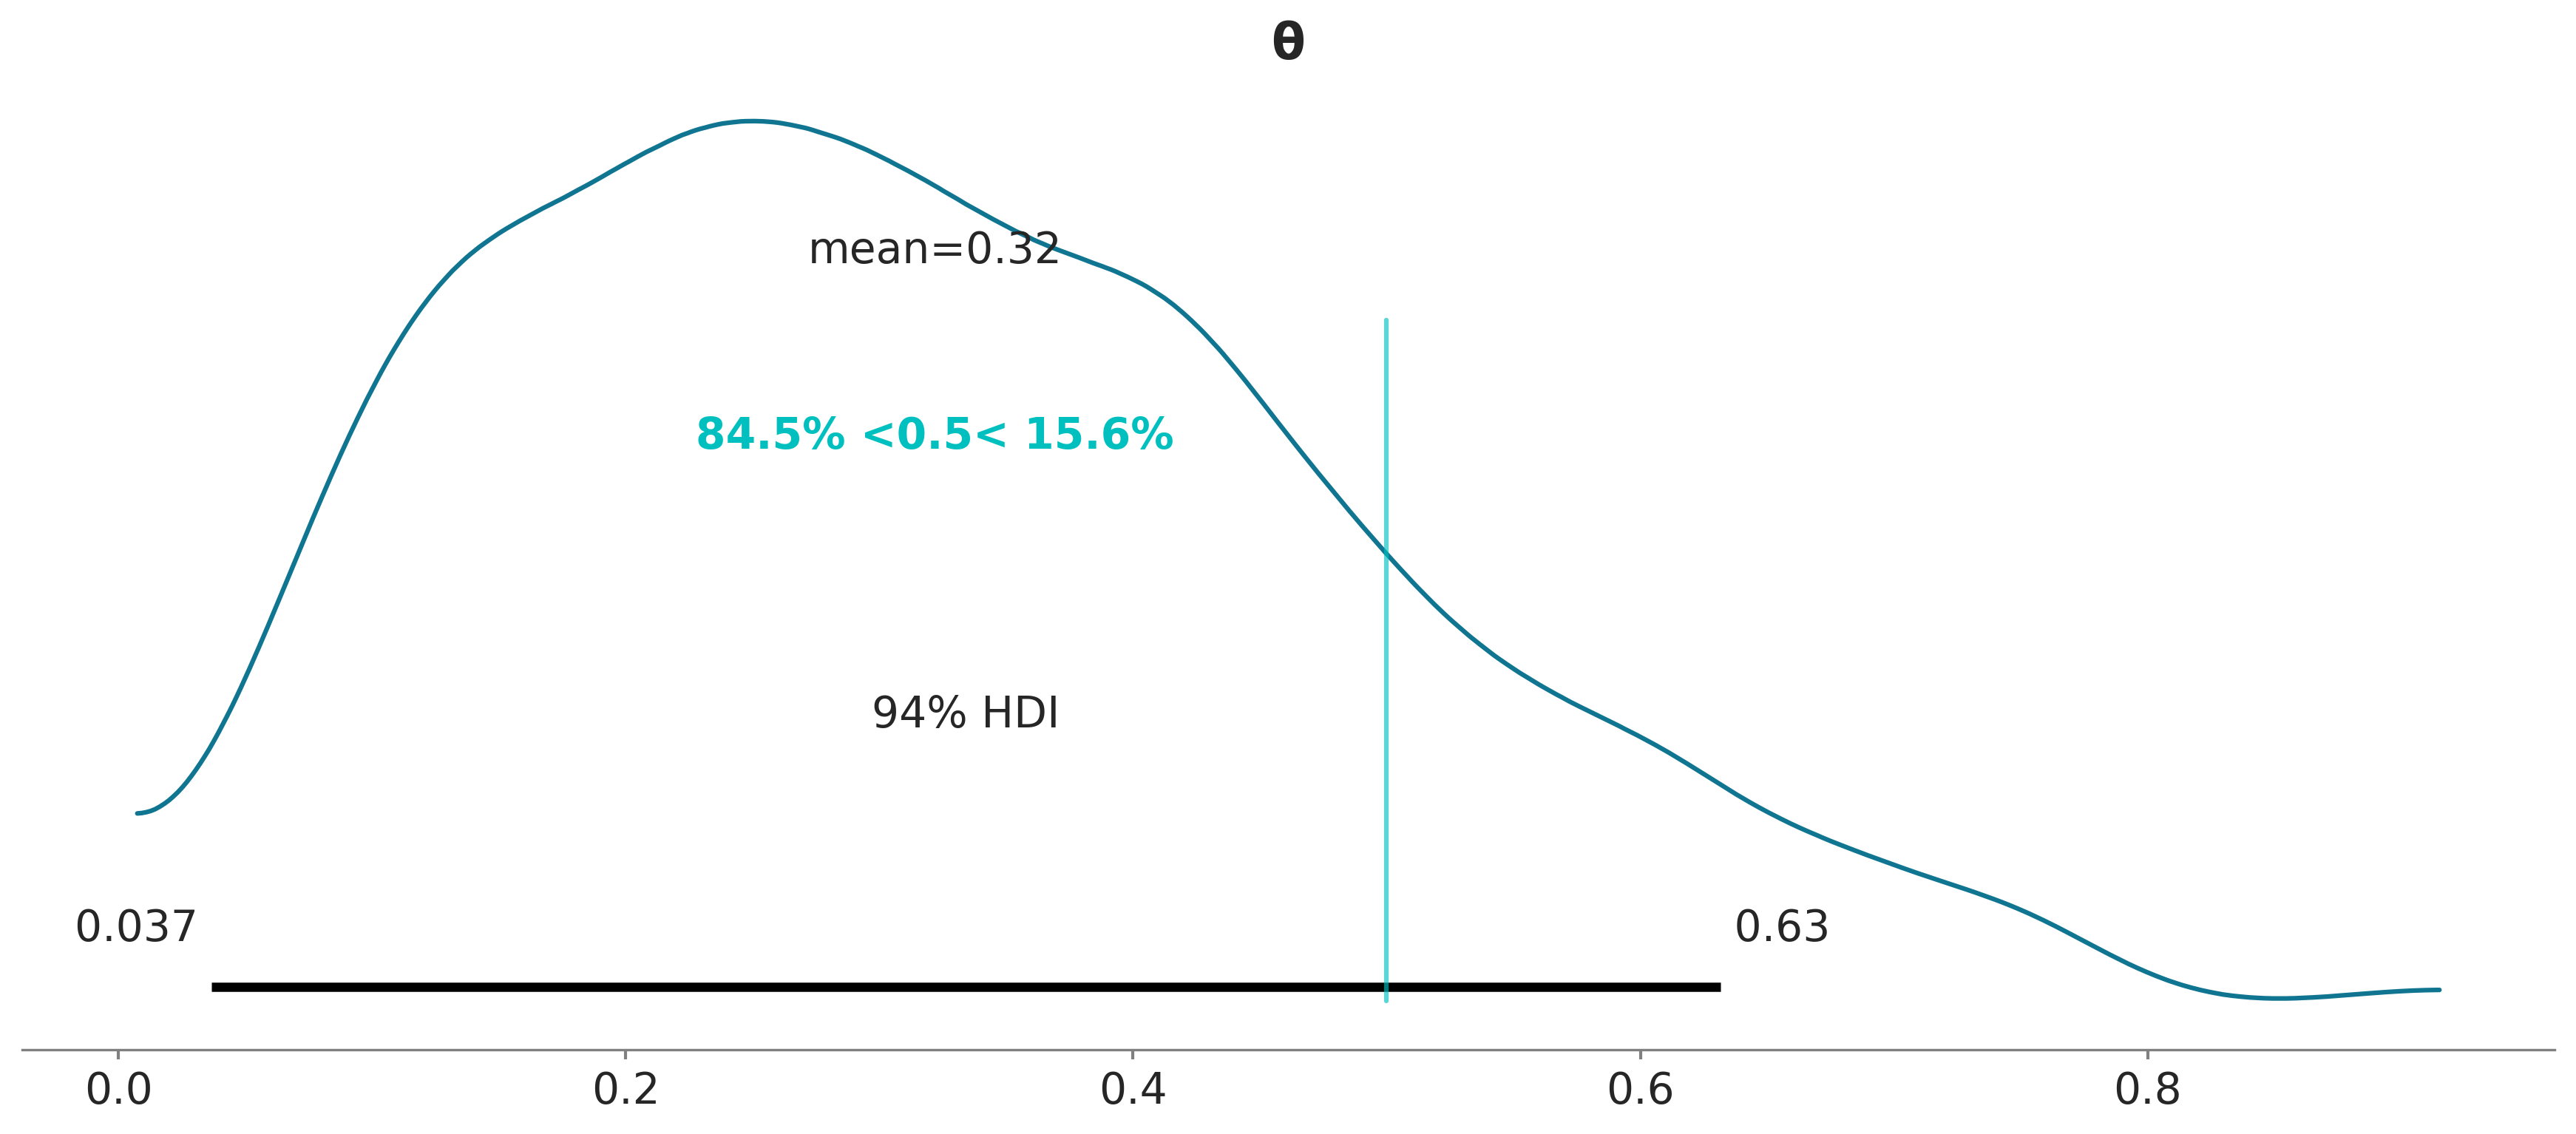

In [14]:
az.plot_posterior(idata, ref_val=0.5);

### Loss functions
- More formal alternative to the use of ROPEs.
- Loss function: A way the measure how distant is the true value to the estimate
  - Quadratic $(\theta - \hat{\theta})^2$
  - Absolute $|\theta - \hat{\theta}|$
  - 0-1 Loss $I(\theta = \hat{\theta})$ being $I$ the indicative function

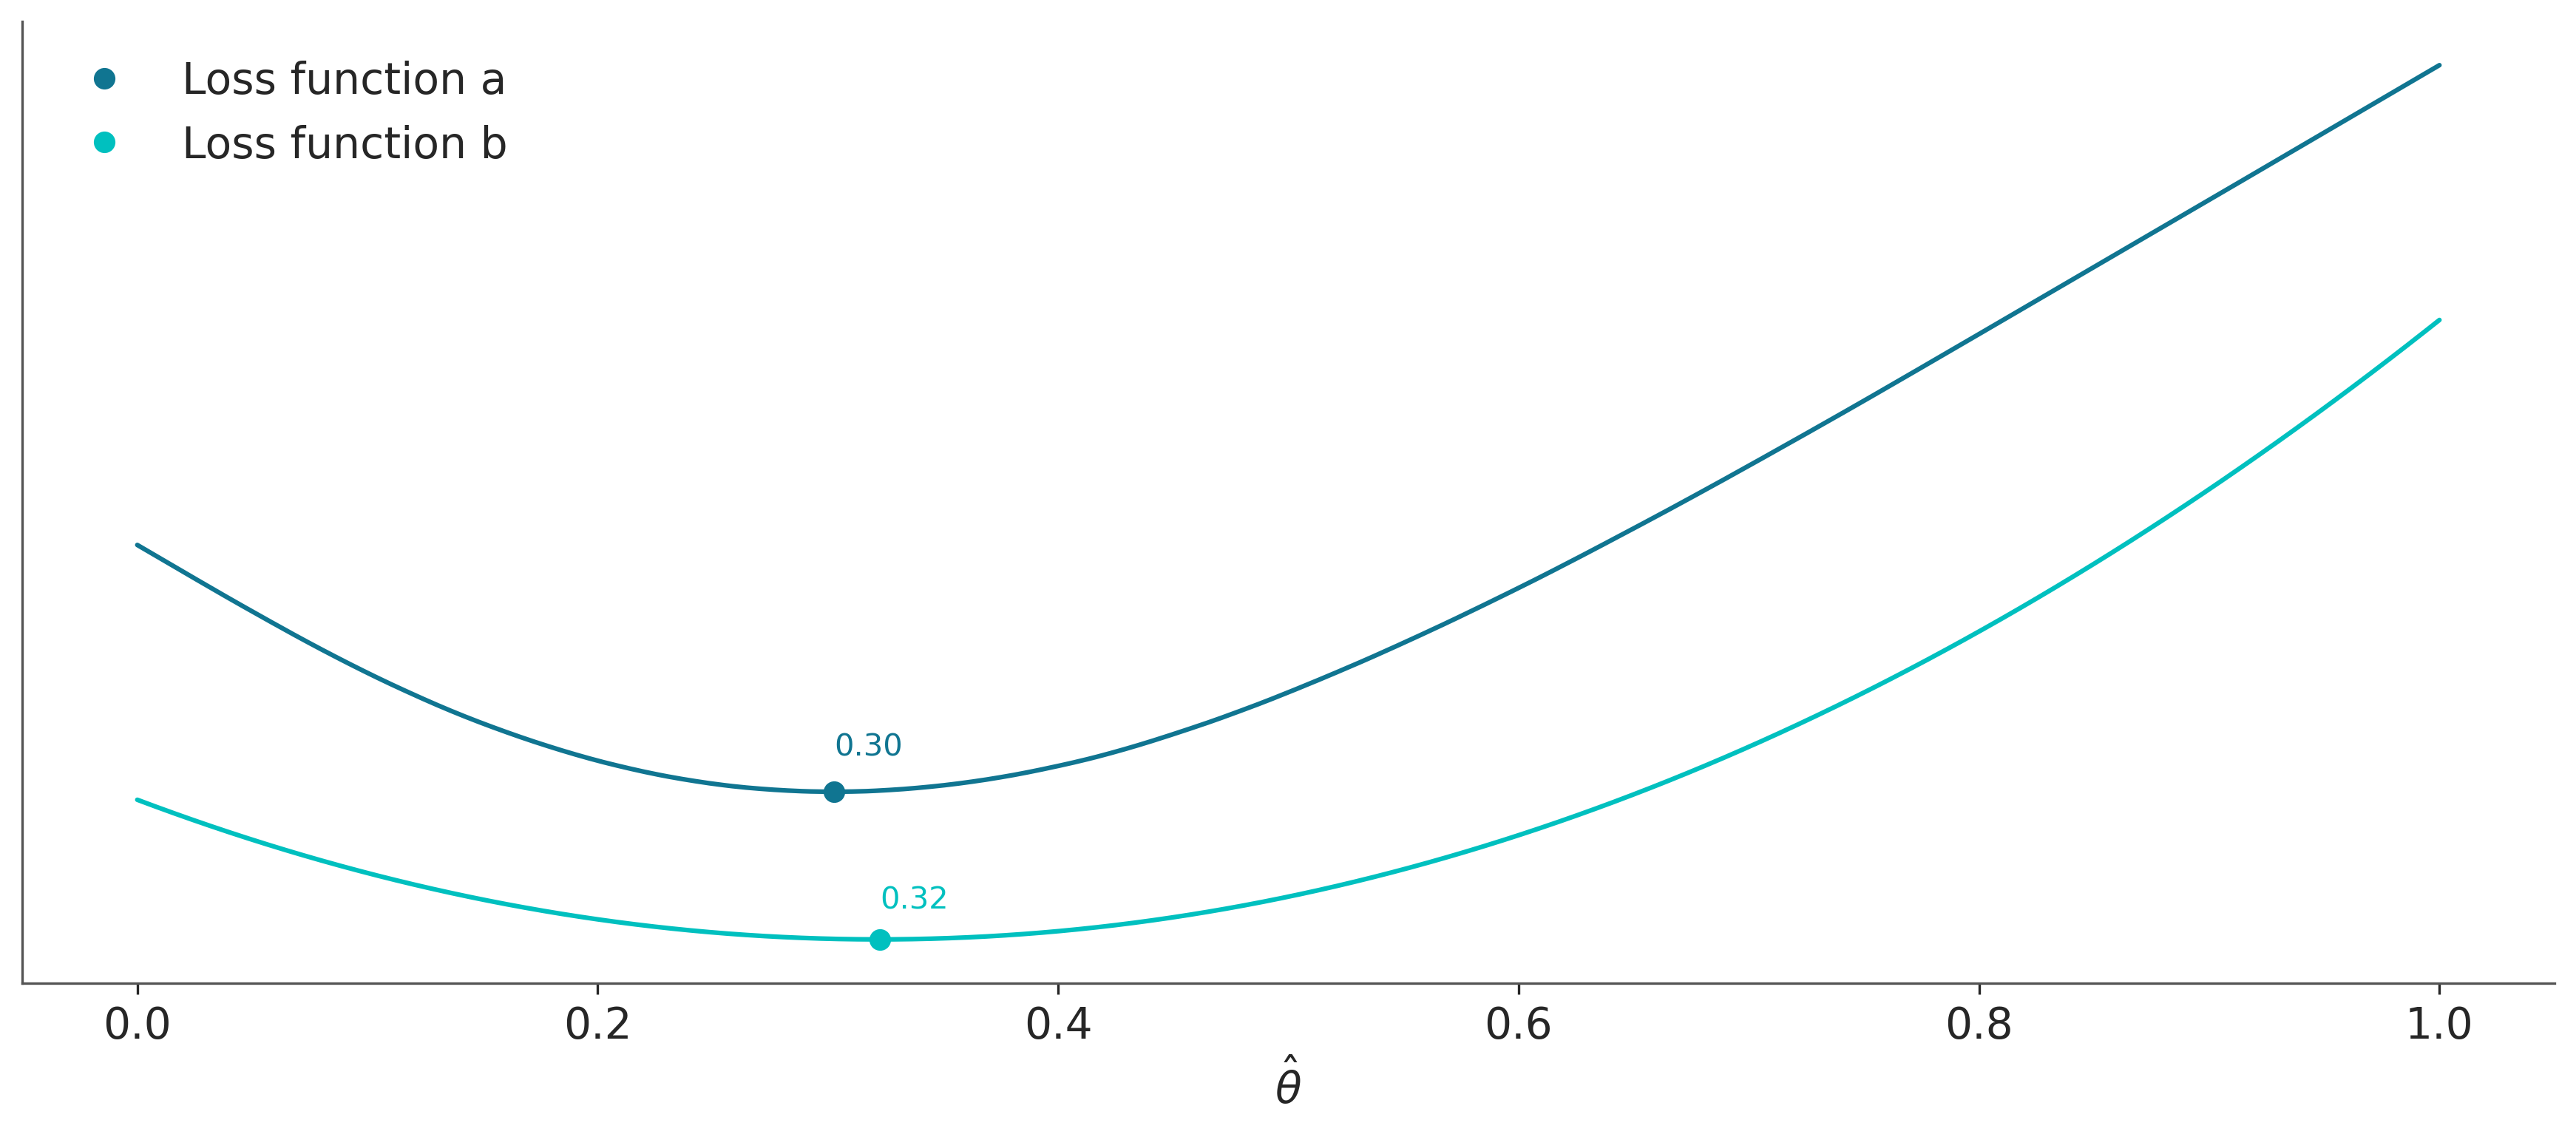

In [15]:
_, ax = plt.subplots(1)
grid = np.linspace(0, 1, 500)
θ_pos = az.extract(idata, var_names="θ")
lossf_a = [np.mean(abs(i - θ_pos)) for i in grid]
lossf_b = [np.mean((i - θ_pos) ** 2) for i in grid]

for i, (lossf, c) in enumerate(zip([lossf_a, lossf_b], ["C0", "C1"])):
    mini = np.argmin(lossf)
    ax.plot(grid, lossf, c)
    ax.plot(
        grid[mini],
        lossf[mini],
        "o",
        color=c,
        label=f"Loss function {['a','b'][i]}",
    )
    pos = (np.max(lossf) - np.min(lossf)) * 0.05
    ax.annotate(f"{grid[mini]:.2f}", (grid[mini], lossf[mini] + pos), color=c)
    ax.set_yticks([])
    ax.set_xlabel(r"$\hat \theta$")
    ax.legend()

In [17]:
np.median(θ_pos).item(), np.mean(θ_pos).item() #First value corresponds to the median and second the mean
# Different loss functions corresponds to different point estimates

(0.3031053341187, 0.32193493960808484)

# Multiparameter Models
- For simplicity, assuming data is gaussian distributed
- A model can be 
  - $\mu \sim U(l,h)$ Mean comes from an uniform distribution between $l$ and $h$
  - $\sigma \sim HN(\sigma_{\sigma})$ Standard deviation comes from an Half Normal distribution with std $\sigma_{sigma}$
  - $y \sim N(\mu,\sigma)$ y comes from a normal distribution parametrized by the two values above

In [18]:
data = np.array([248.28, 248.26, 248.33, 248.24, 248.34, 247.56, 248.27, 248.16,
                  248.4, 247.98, 248.29, 248.22, 248.24, 248.21, 248.25, 248.3,
                  248.23, 248.29, 248.31, 248.19, 248.24, 248.2, 248.36, 248.32,
                  248.36, 248.28, 248.25, 248.21, 248.28, 248.29, 248.37, 248.25,
                  248.28, 248.26, 248.3, 248.32, 248.36, 248.26, 248.3, 248.22,
                  248.36, 248.23, 248.27, 248.27, 248.28, 248.27, 248.31, 248.27,
                  248.26, 248.33, 248.26, 248.32, 248.32, 248.24, 248.39, 248.28,
                  248.24, 248.25, 248.32, 248.25, 248.29, 248.27, 248.28, 248.29,
                  248.16, 248.23])

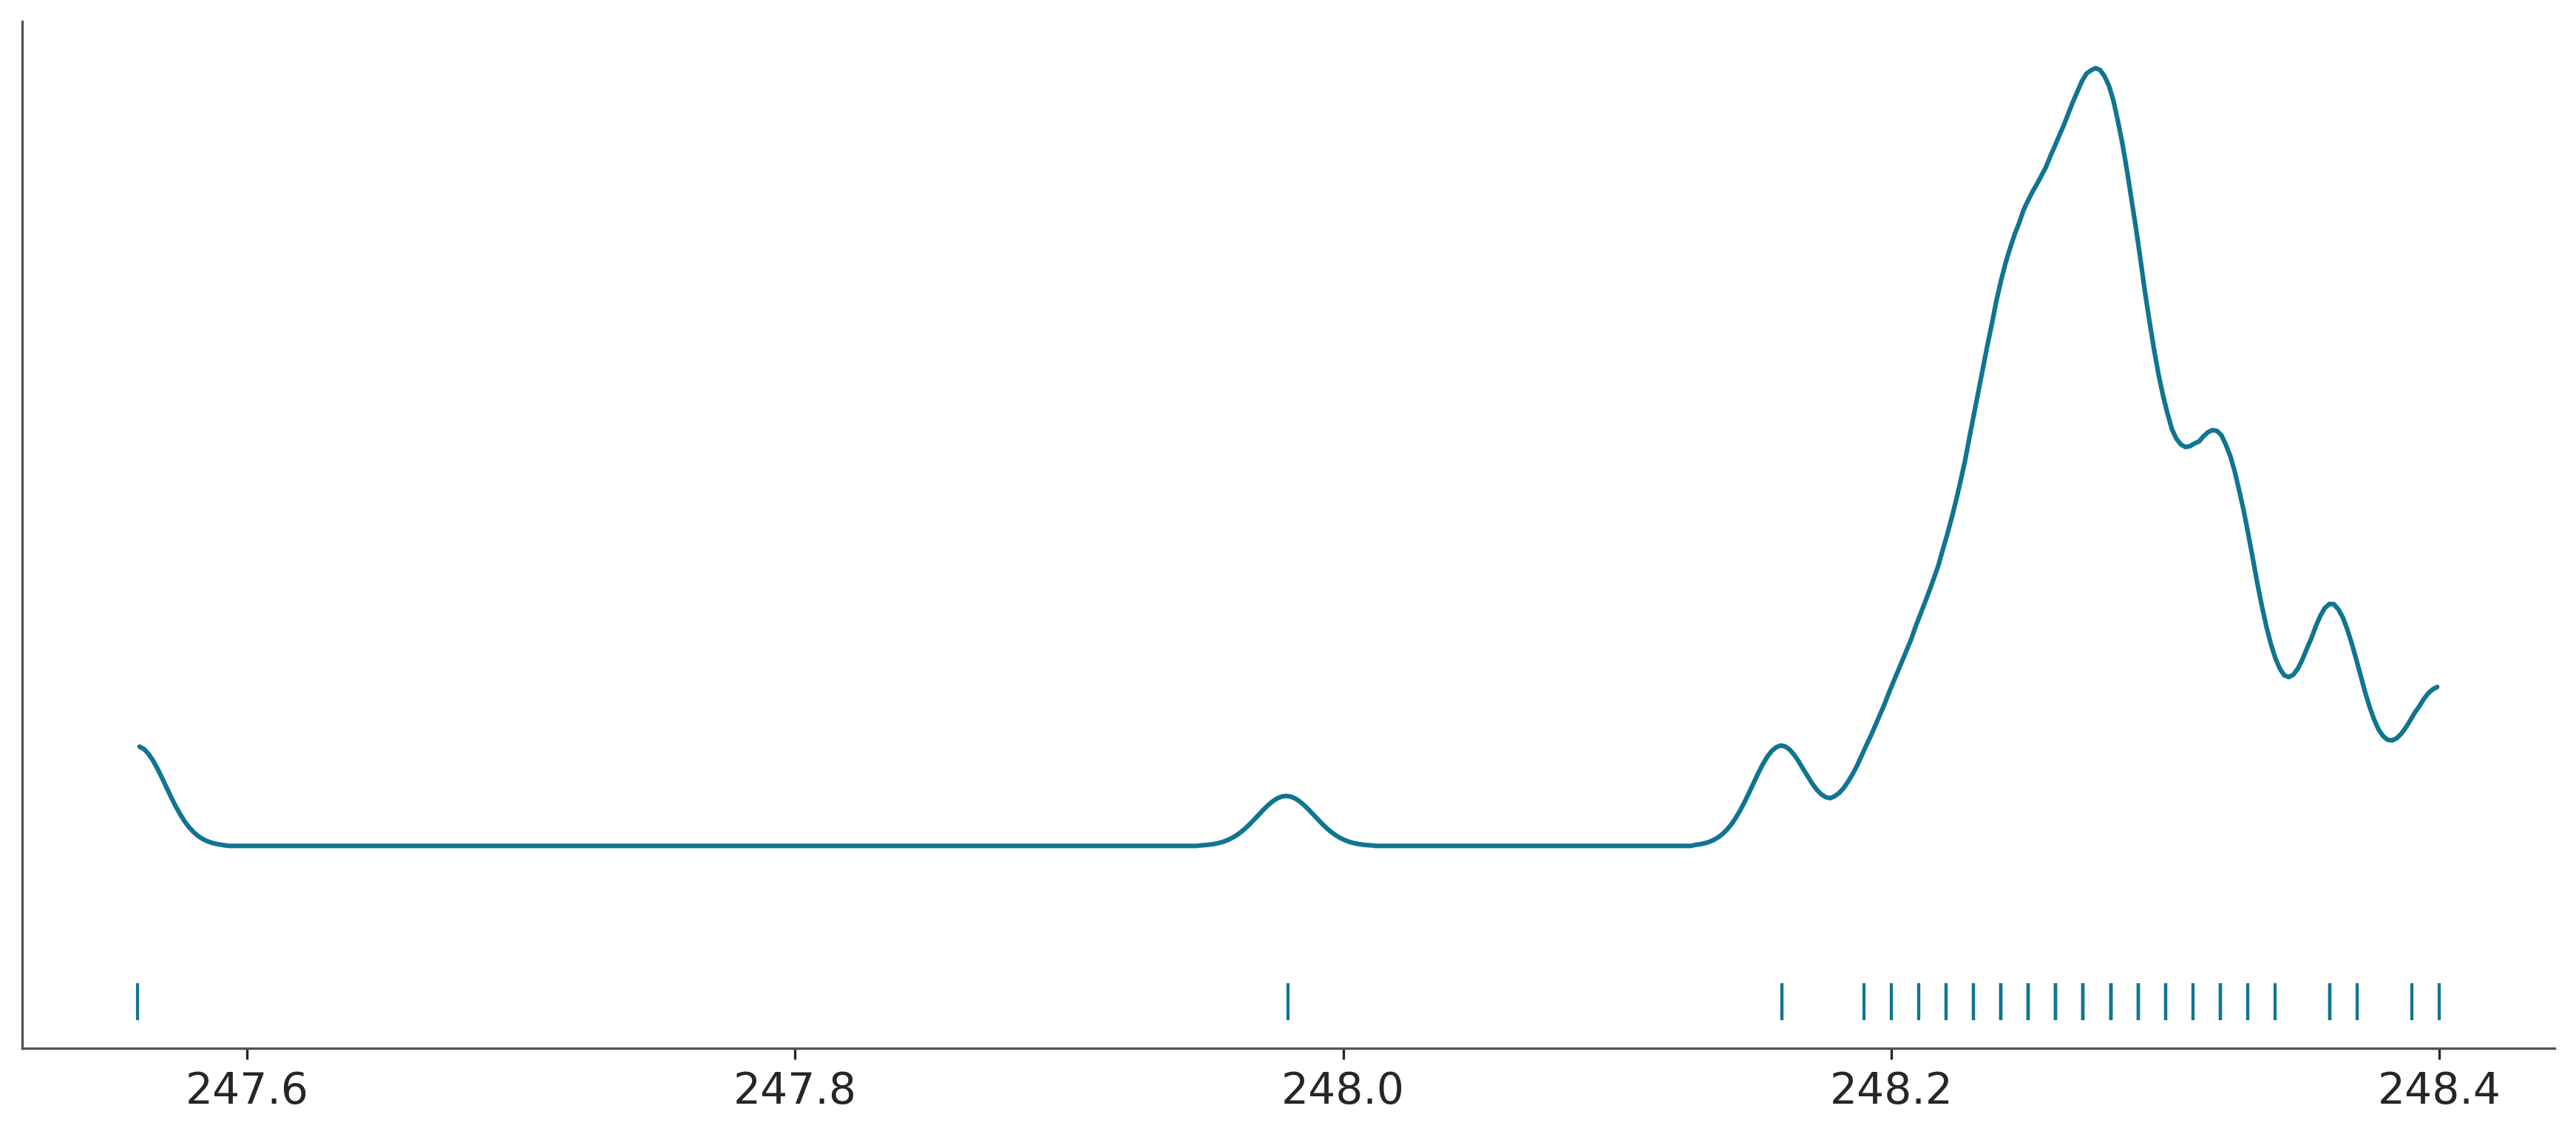

In [20]:
ax = az.plot_kde(data, rug=True)
ax.set_yticks([]);

In [21]:
with pm.Model() as modelo_g:
    μ = pm.Uniform("μ", 240, 250)
    σ = pm.HalfNormal("σ", sigma=1)
    y = pm.Normal("y", mu=μ, sigma=σ, observed=data)
    idata_g = pm.sample()

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [μ, σ]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 26 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics


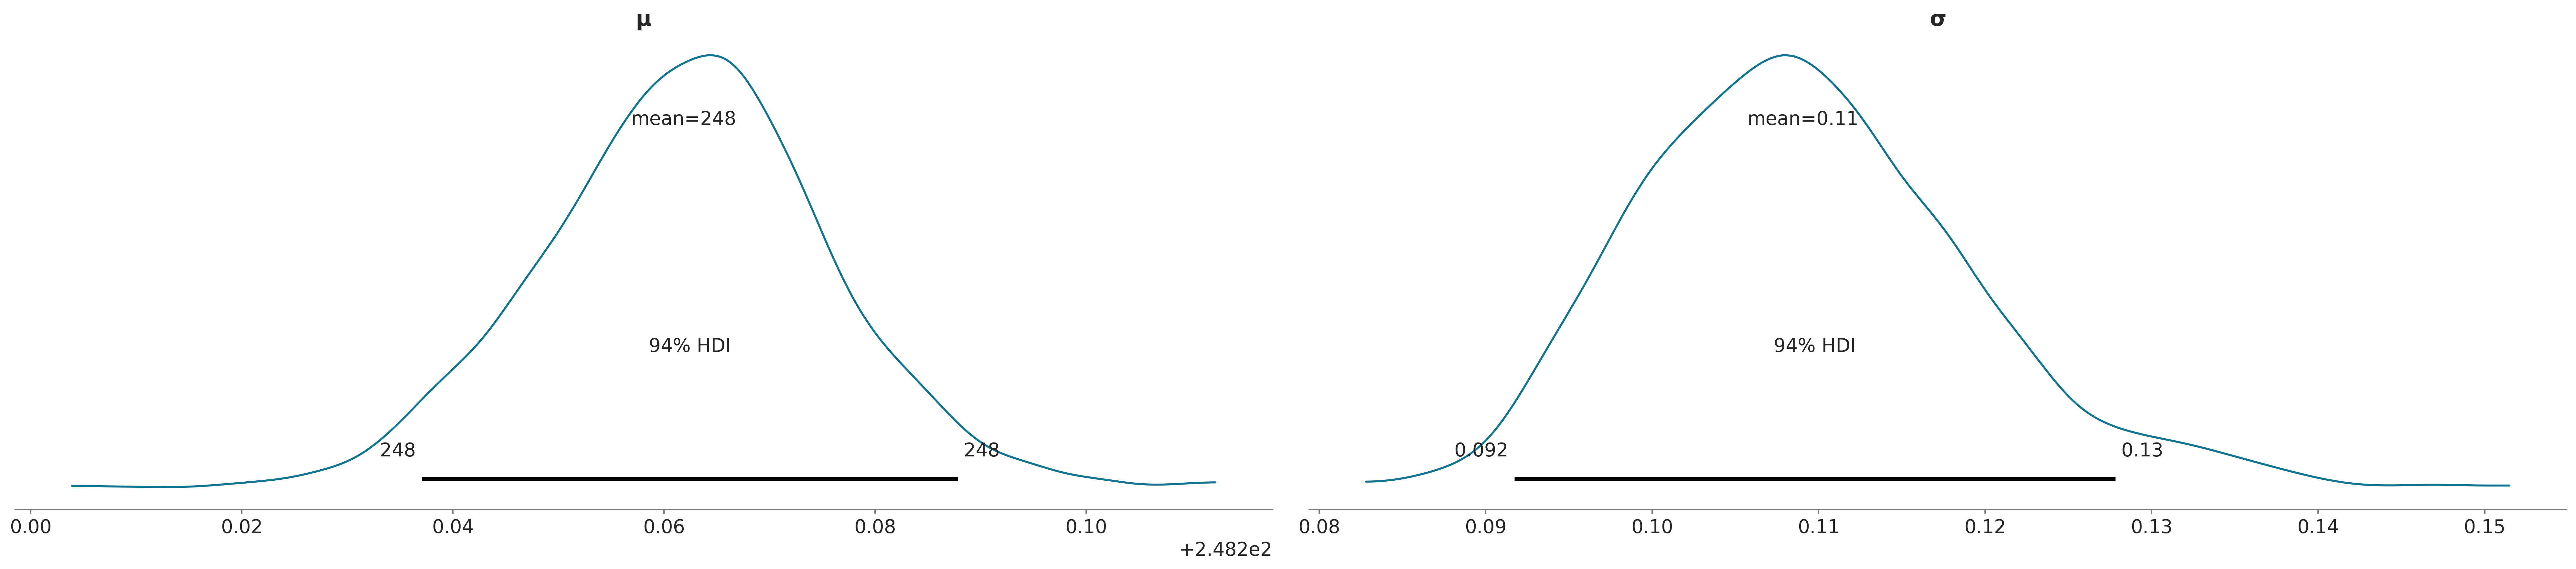

In [23]:
az.plot_posterior(idata_g);

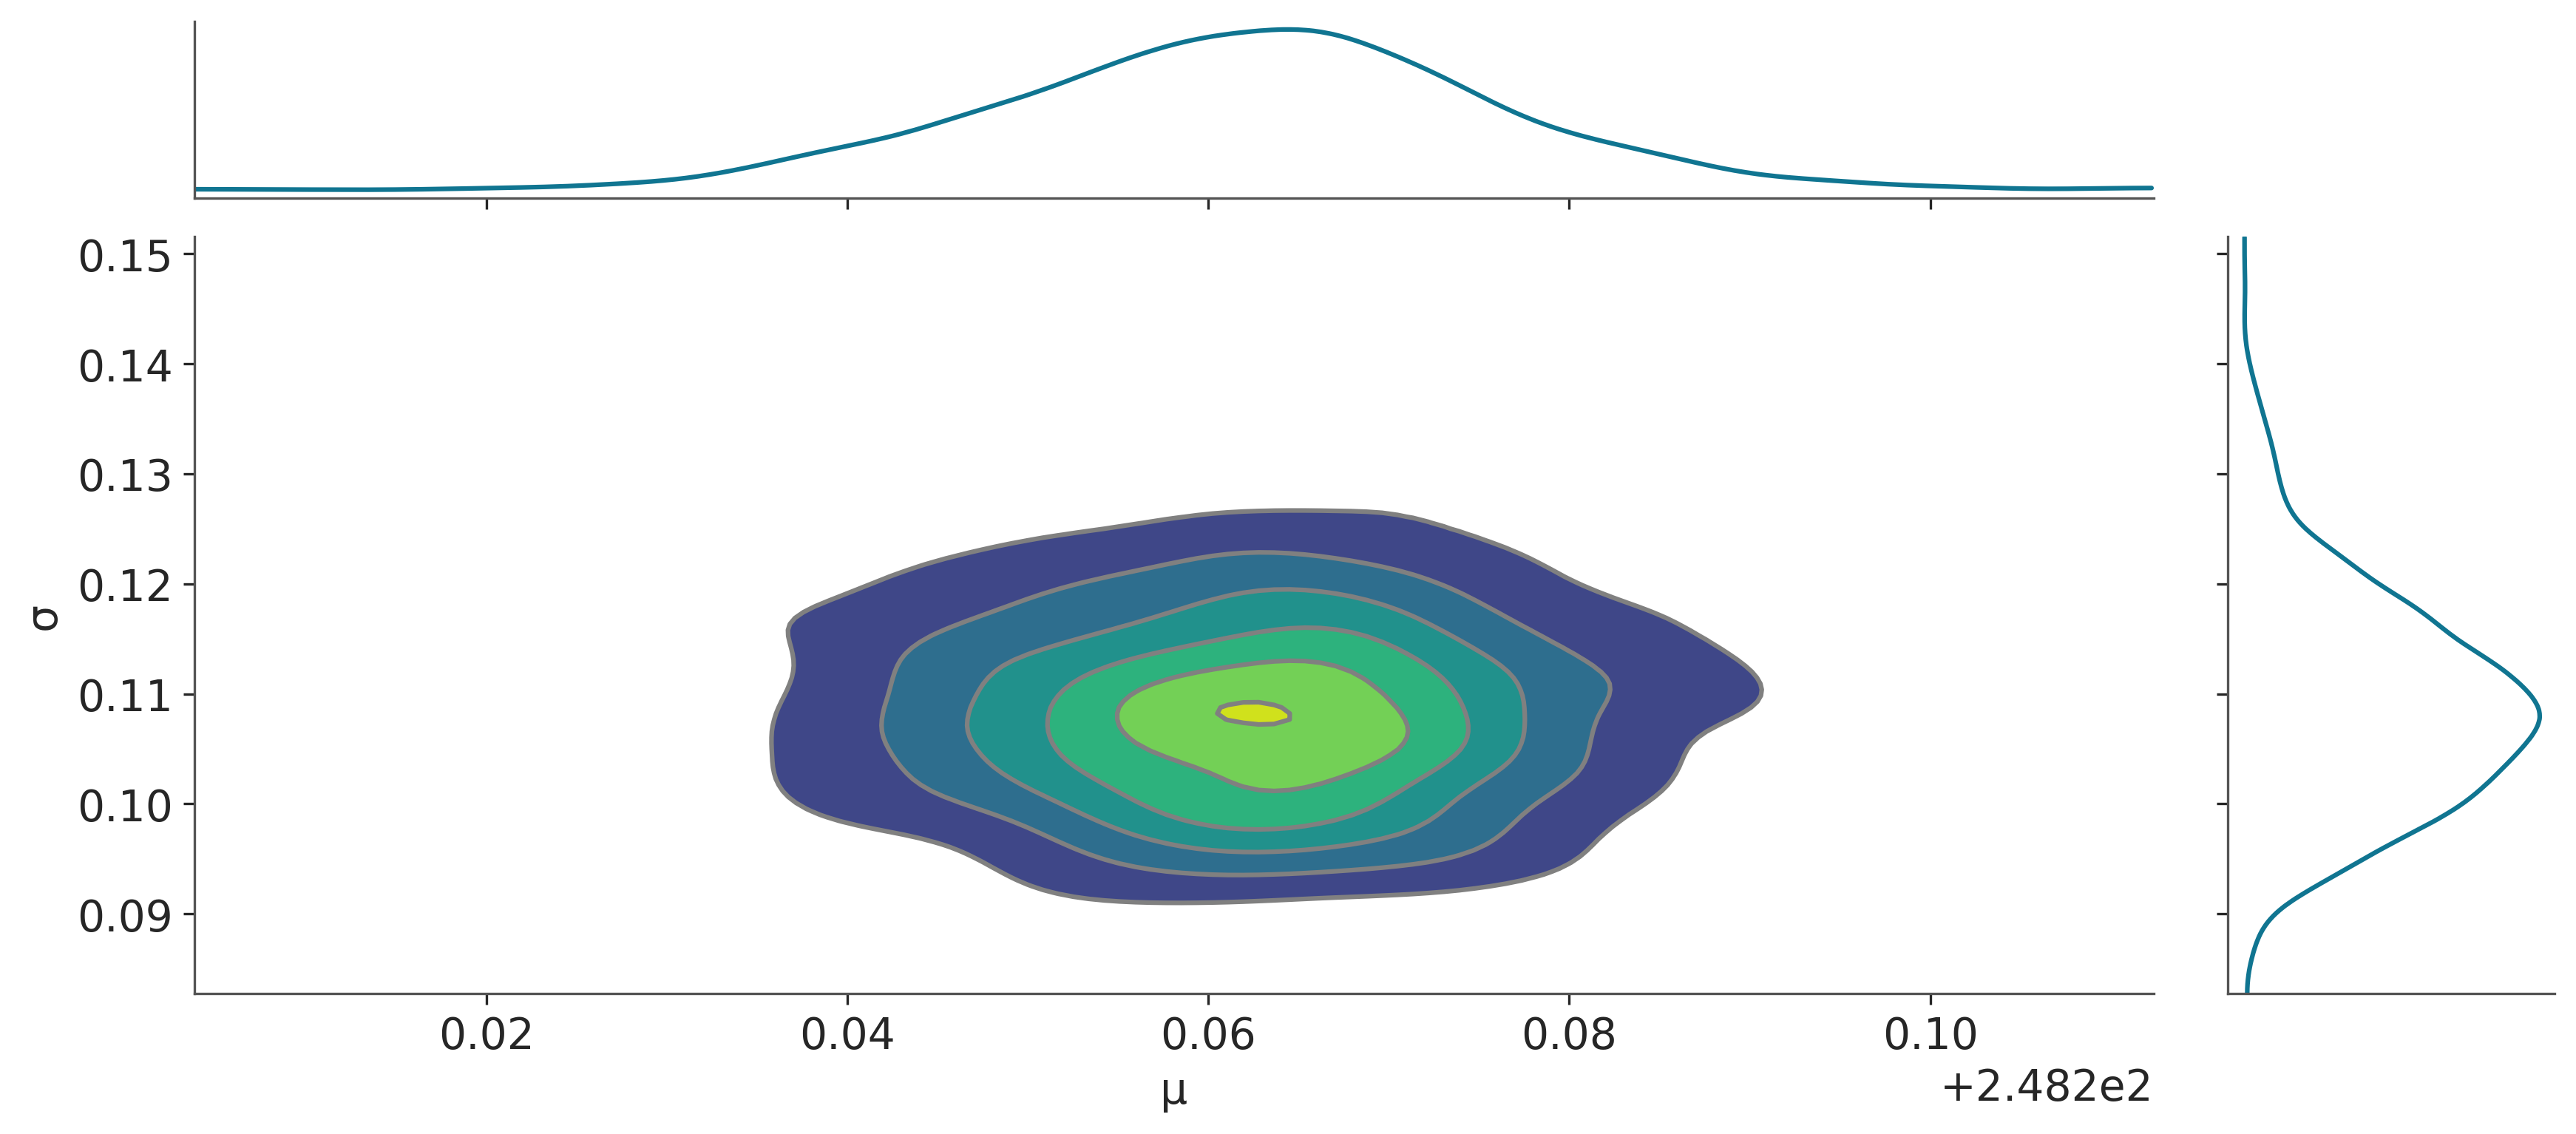

In [22]:
az.plot_pair(idata_g, kind="kde", marginals=True);

- Once the posterior has been computed, we can use it to compute the posterior predictive distribution, given by $$ p(\tilde{y}|y) = \int p(\tilde{y}|\theta)p(\theta|y)d\theta$$
- Choose a random sample from those generated by PyMC
- Generate synthetic data using the same likelihood as used in the model
- Repeat above steps as many times needed

In [24]:
ppc_g = pm.sample_posterior_predictive(idata_g, model=modelo_g)

Sampling: [y]


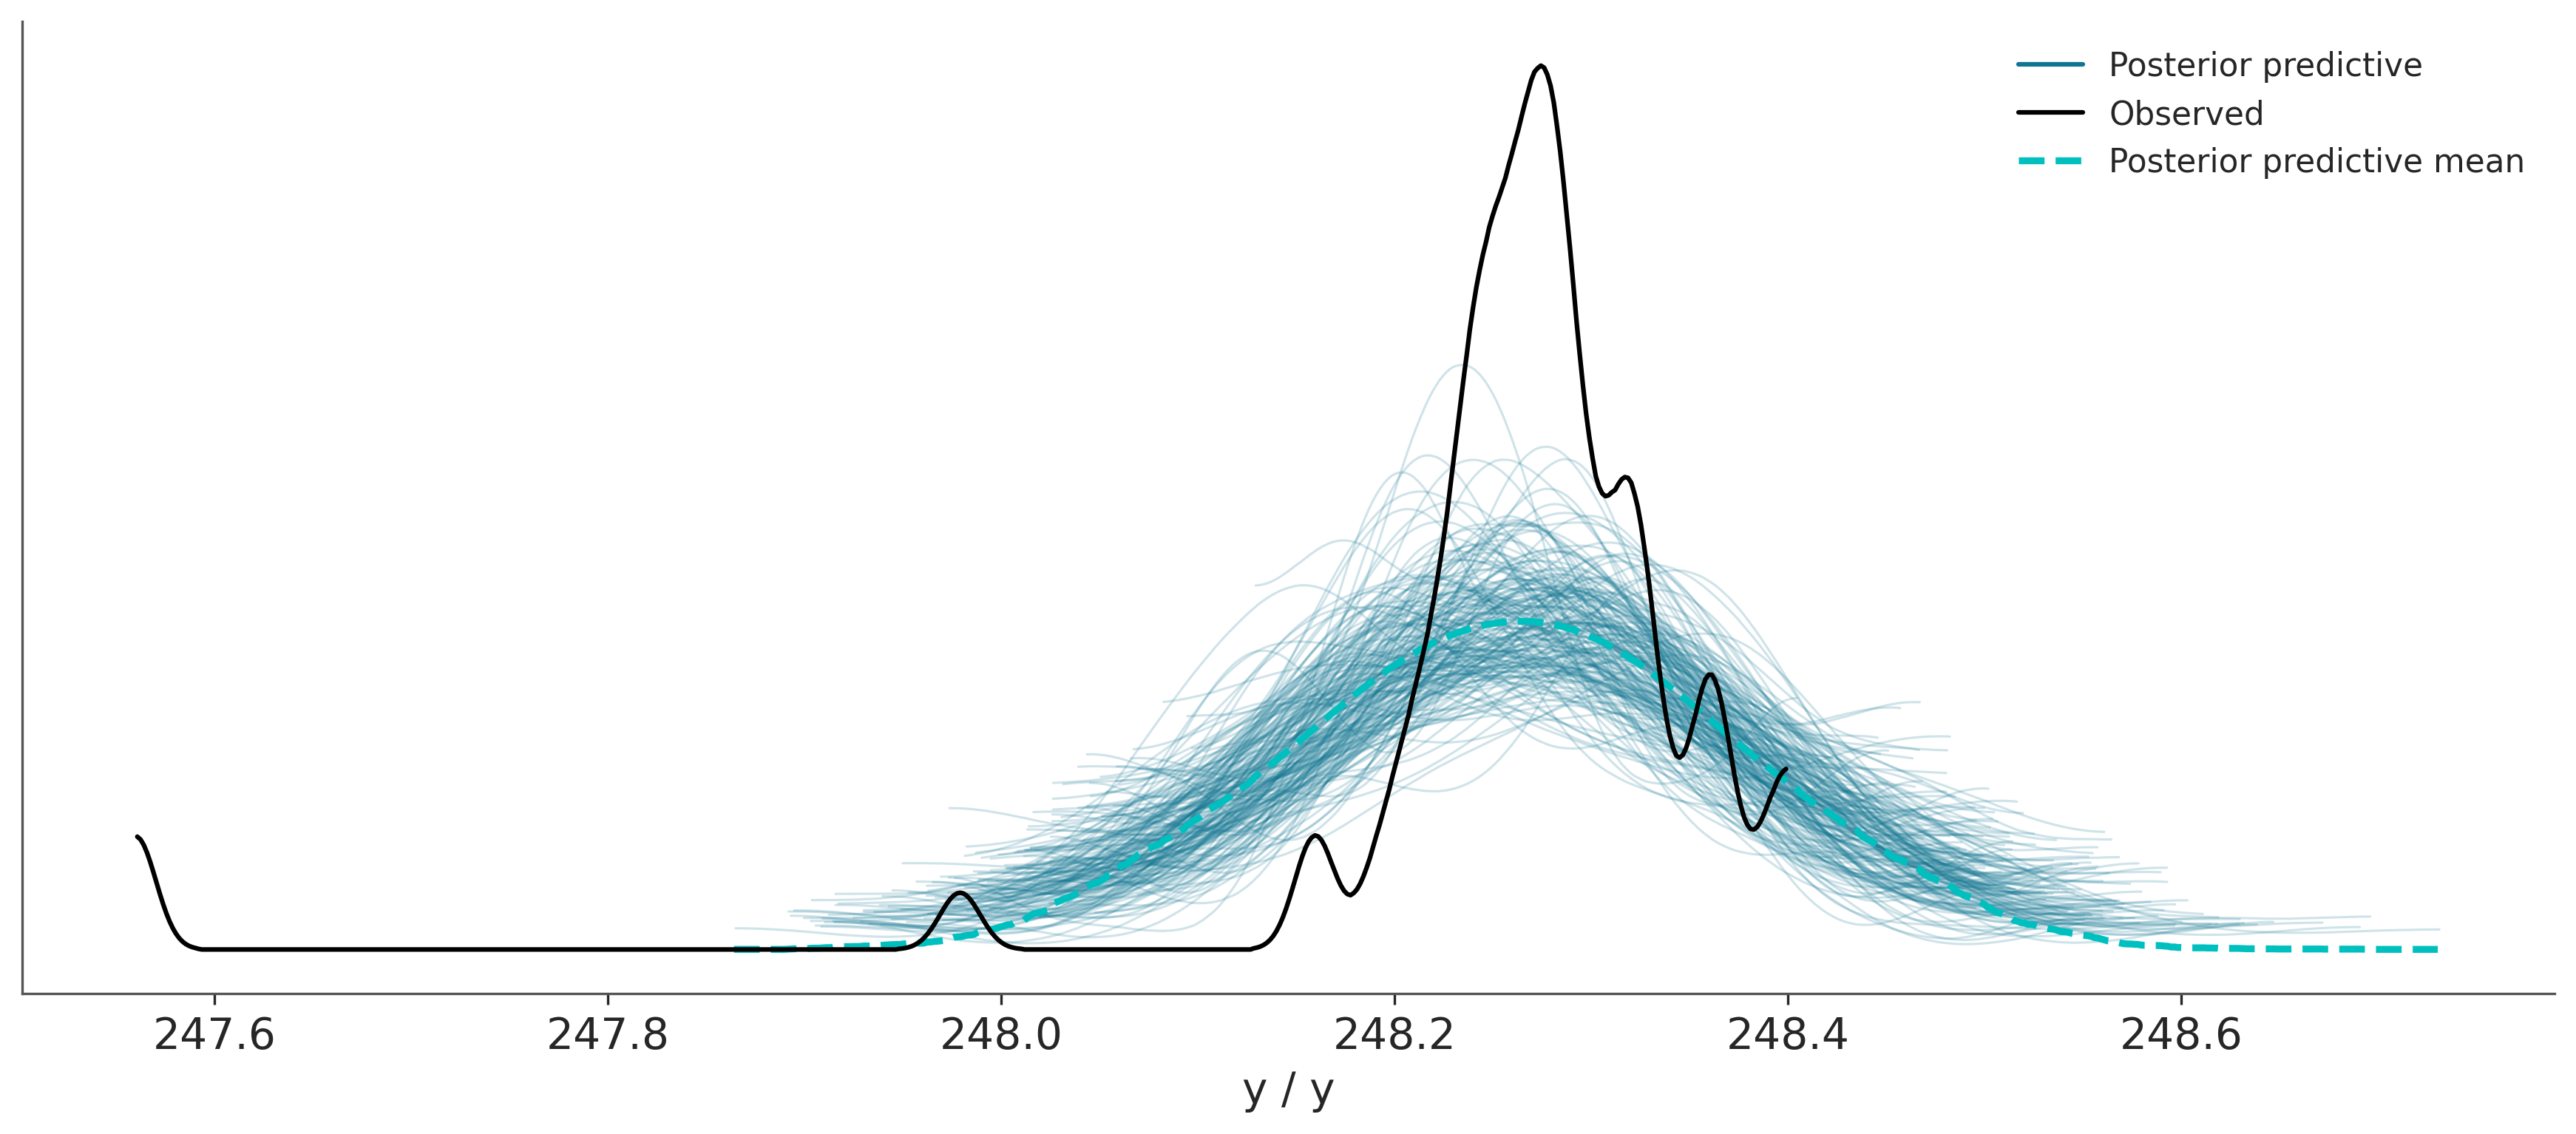

In [25]:
az.plot_ppc(ppc_g, num_pp_samples=200);

## Robust Models
- Model assumes a normal distribution, but it isnt exactly like one
- Drawbacks of assuming normality
  - Mean is very sensitive to outliers
- Alternative is to use Student-T distribution
  - Degrees of freedom parameter: 
    - Controls how heavy the the tails of the distribution are
    - As this goes to infinity, it approaches a Gaussian
- The problem can be modeled as
  - $\mu \sim U(l,h)$ 
  - $\sigma \sim HN(\sigma_{\sigma})$ 
  - $\mathbb{v} \sim Exp(\lambda)$ Ensures that $v \geq 1$
  - $y \sim StudentT(\mu,\sigma,v)$

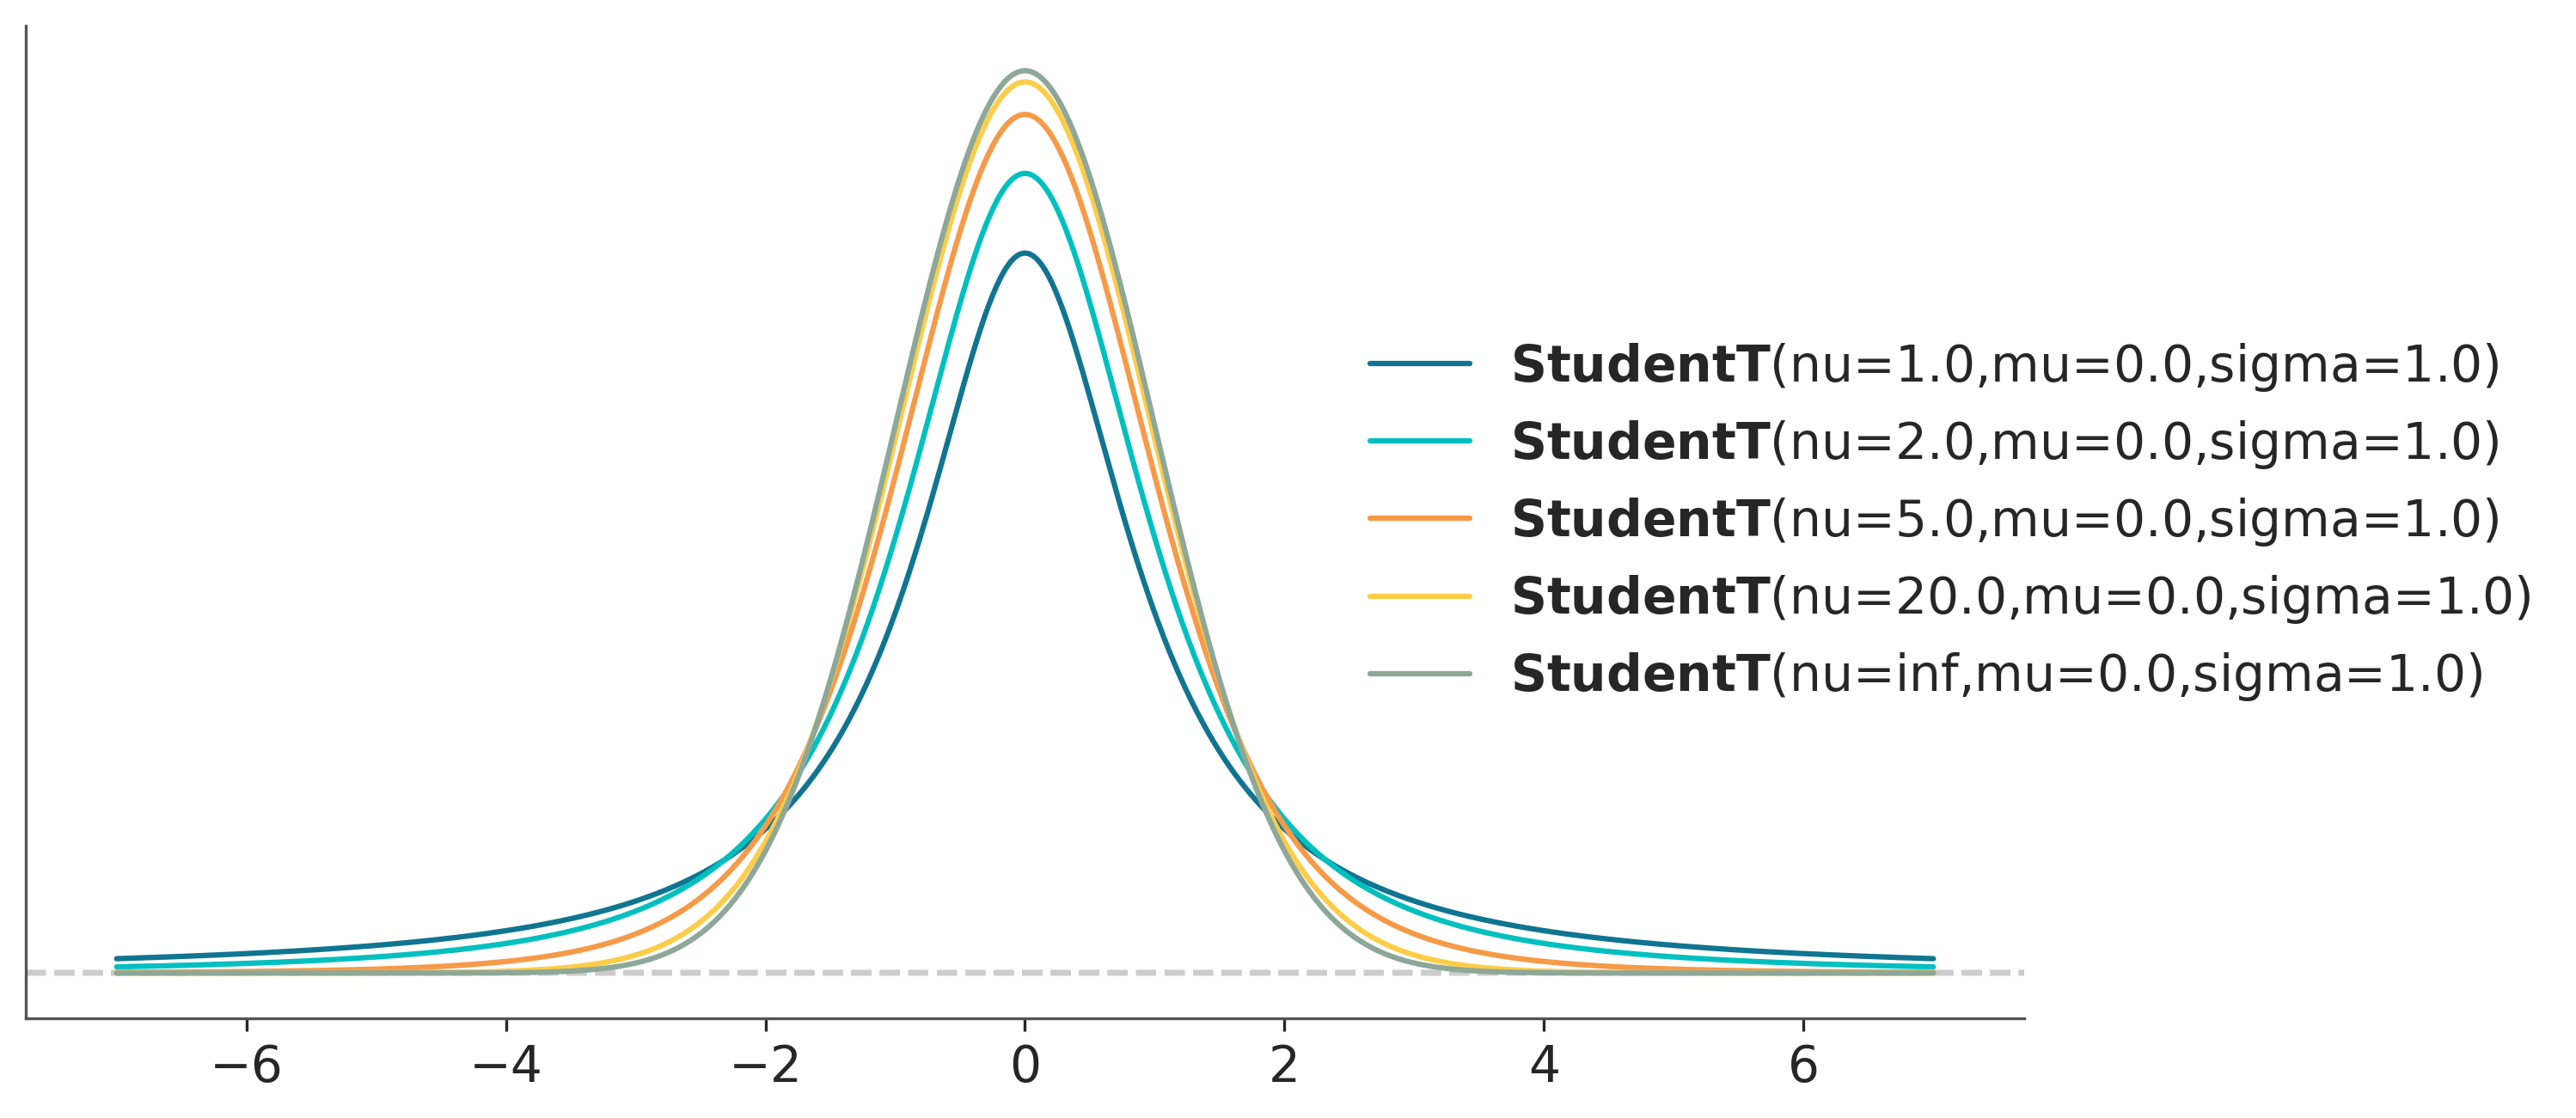

In [26]:
_, ax = plt.subplots(figsize=(10, 5))

x_values = np.linspace(-10, 10, 500)
for df in [1, 2, 5, 20, np.inf]:
    ax = pz.StudentT(df, 0, 1).plot_pdf(support=(-7, 7))
ax.legend(loc="center left", bbox_to_anchor=(0.65, 0.5));

In [27]:
with pm.Model() as modelo_t:
    μ = pm.Uniform("μ", 240, 250)
    σ = pm.HalfNormal("σ", sigma=100)
    ν = pm.Exponential("ν", 1 / 30)
    y = pm.StudentT("y", mu=μ, sigma=σ, nu=ν, observed=data)
    idata_t = pm.sample()

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [μ, σ, ν]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 29 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics


In [32]:
az.summary(idata_g)

mean     sd   hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  ess_tail  \
μ  248.262  0.014  248.237  248.288        0.0      0.0    2094.0    1504.0   
σ    0.109  0.010    0.092    0.128        0.0      0.0    1977.0    1452.0   

   r_hat  
μ    1.0  
σ    1.0

In [28]:
az.summary(idata_t)

mean     sd   hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  ess_tail  \
μ  248.274  0.006  248.263  248.286      0.000    0.000    1512.0    1175.0   
σ    0.041  0.007    0.030    0.054      0.000    0.000    1243.0    1159.0   
ν    2.636  0.909    1.208    4.222      0.025    0.018    1329.0    1292.0   

   r_hat  
μ    1.0  
σ    1.0  
ν    1.0

In [30]:
ppc_t = pm.sample_posterior_predictive(idata_t, model=modelo_t)

Sampling: [y]


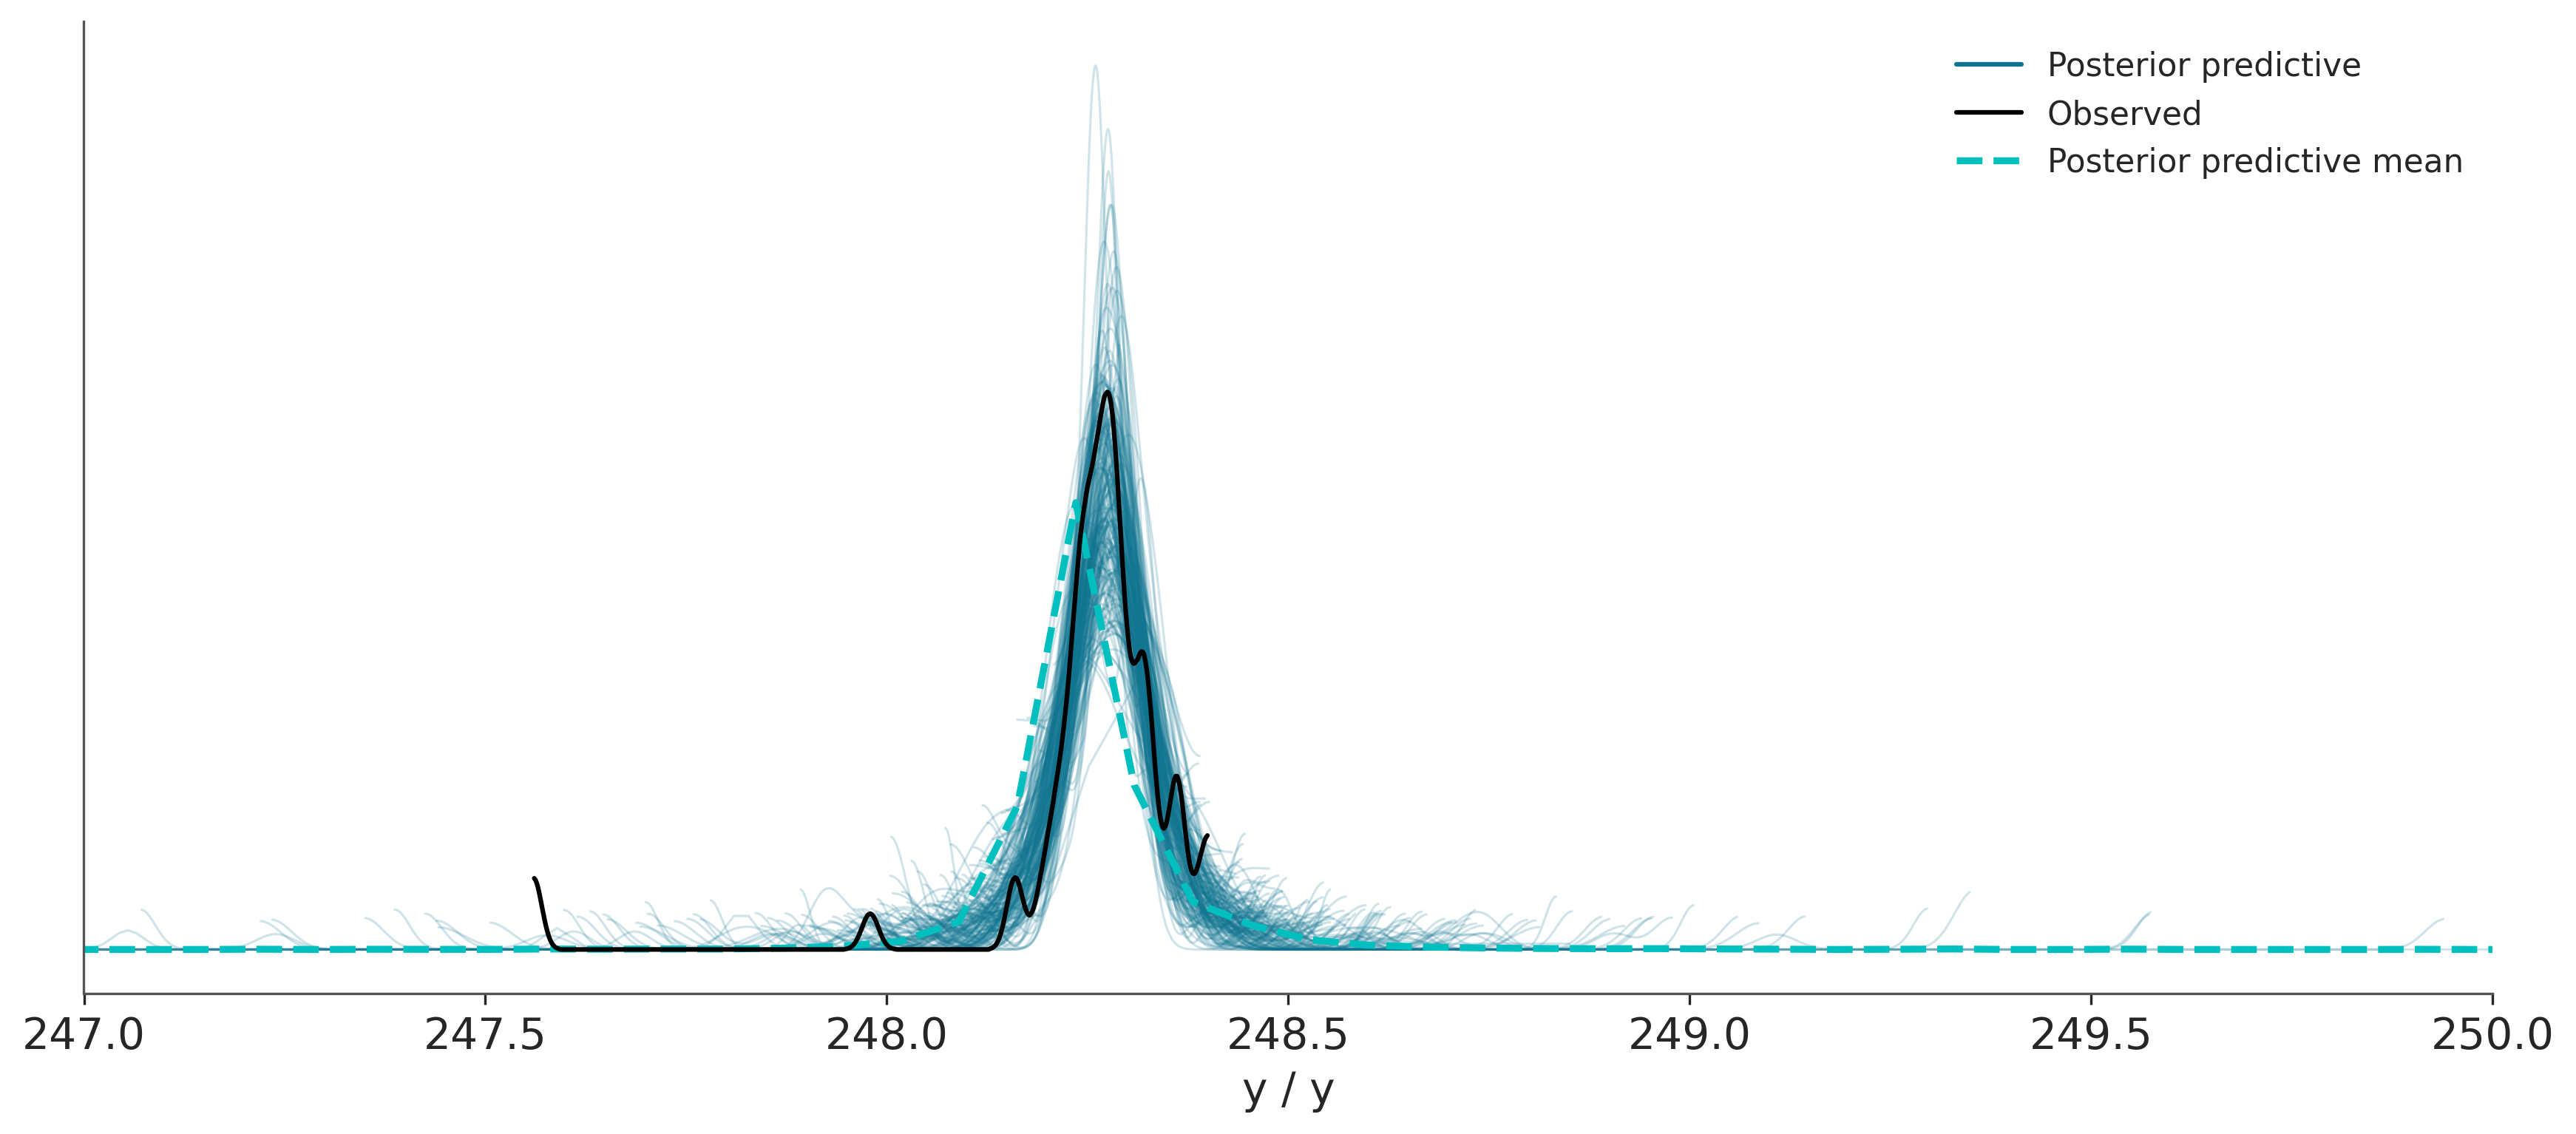

In [31]:
az.plot_ppc(ppc_t, num_pp_samples=200)
plt.xlim(247, 250);

### Example: Coal Mining Disaster
- Number of accidents -> Poisson distribution (integer count)
- Since we believe there is a difference before/after regulations, estimate cutoff point which will divide the years for which the accident rate applies
$$A_{t} = Poisson(tasa)$$
$$tasa=\begin{cases} 
t_{0}, & if & t \geq pc \\
t_{1} & if & t  < pc
\end{cases}
$$
- Priors
  - $t_{0} = Exp(1)$
  - $t_{1} = Exp(1)$
  - $\text{changepoint} = U(Y_{1},Y_{N})$

In [33]:
data = pd.Series([4, 5, 4, 0, 1, 4, 3, 4, 0, 6, 3, 3, 4, 0, 2, 6,
                       3, 3, 5, 4, 5, 3, 1, 4, 4, 1, 5, 5, 3, 4, 2, 5,
                       2, 2, 3, 4, 2, 1, 3, np.nan, 2, 1, 1, 1, 1, 3, 0, 0,
                       1, 0, 1, 1, 0, 0, 3, 1, 0, 3, 2, 2, 0, 1, 1, 1,
                       0, 1, 0, 1, 0, 0, 0, 2, 1, 0, 0, 0, 1, 1, 0, 2,
                       3, 3, 1, np.nan, 2, 1, 1, 1, 1, 2, 4, 2, 0, 0, 1, 4,
                       0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1])
years = np.arange(1851, 1962)

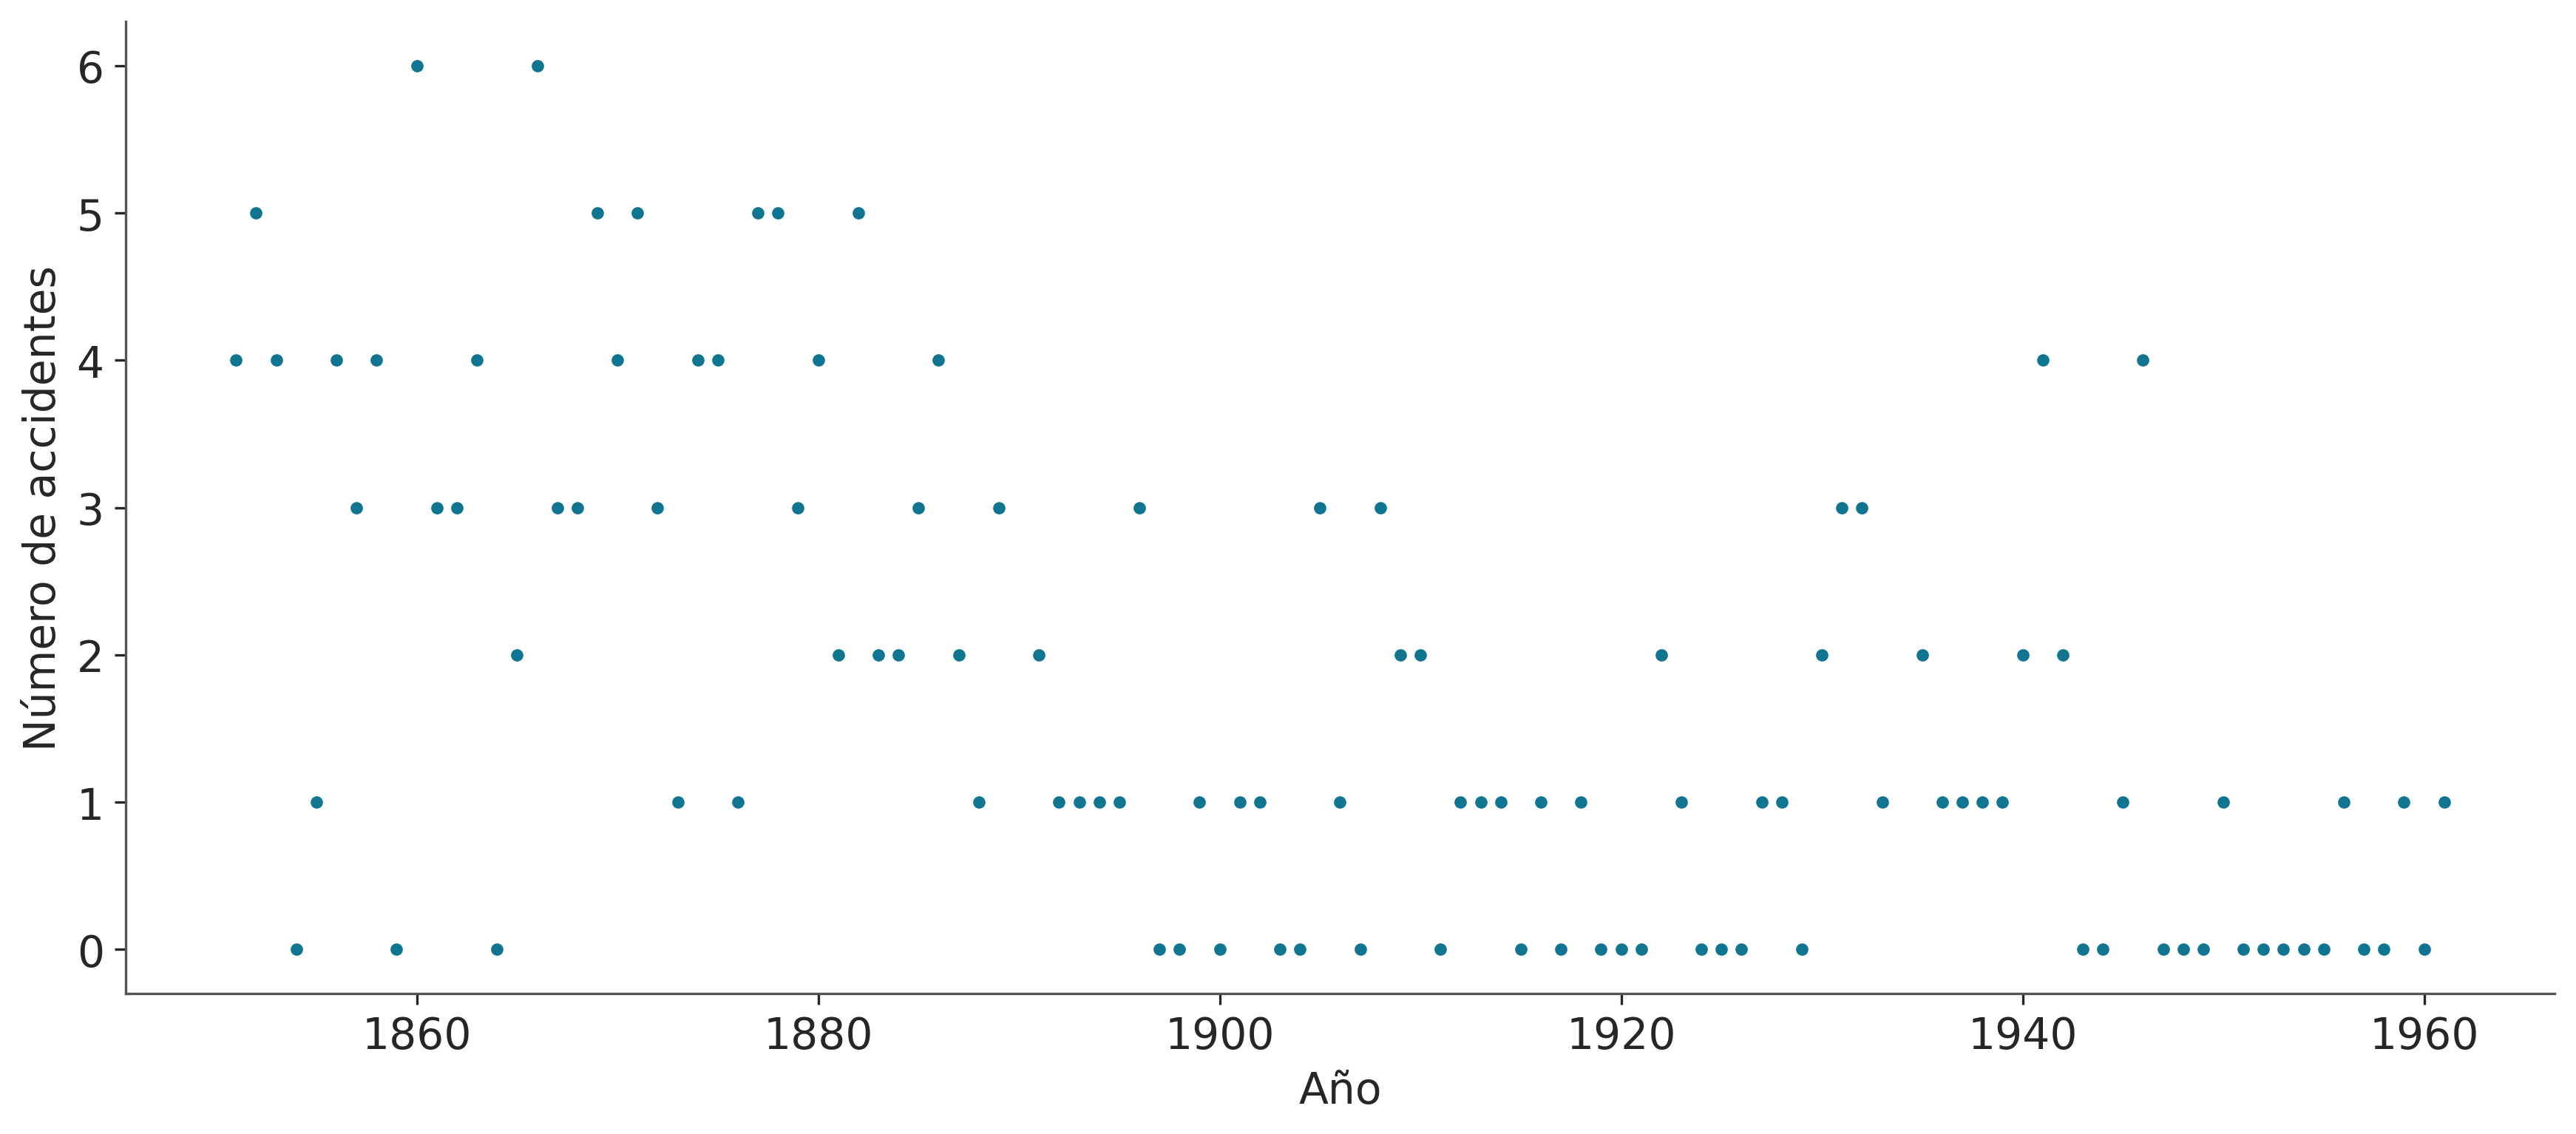

In [34]:
plt.plot(years, data, ".")
plt.ylabel("Número de accidentes")
plt.xlabel("Año");

In [35]:
## Switch -> If the first argument is true, returns the second, else returns the third.
## Result -> Vector of length years corresponding to t0s followed by t1s controlled by the condition 
with pm.Model() as model:

    changepoint = pm.DiscreteUniform("pc", lower=years.min(), upper=years.max())

    t_0 = pm.Exponential("t_0", 1)
    t_1 = pm.Exponential("t_1", 1)

    tasa = pm.Deterministic("tasa", pm.math.switch(changepoint >= years, t_0, t_1))

    acc = pm.Poisson("acc", tasa, observed=data)
    idata_cat = pm.sample(1000, random_seed=1791, idata_kwargs={"log_likelihood": True})

c:\Users\Gabriel\mambaforge\envs\bayes\lib\site-packages\pymc\model\core.py:1342: RuntimeWarning: invalid value encountered in cast
  data = convert_observed_data(data).astype(rv_var.dtype)
c:\Users\Gabriel\mambaforge\envs\bayes\lib\site-packages\pymc\model\core.py:1365: ImputationWarning: Data in acc contains missing values and will be automatically imputed from the sampling distribution.
  warnings.warn(impute_message, ImputationWarning)
Multiprocess sampling (2 chains in 2 jobs)
CompoundStep
>CompoundStep
>>Metropolis: [pc]
>>Metropolis: [acc_unobserved]
>NUTS: [t_0, t_1]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 33 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics


In [36]:
idata_cat

Inference data with groups:
	> posterior
	> log_likelihood
	> sample_stats
	> observed_data

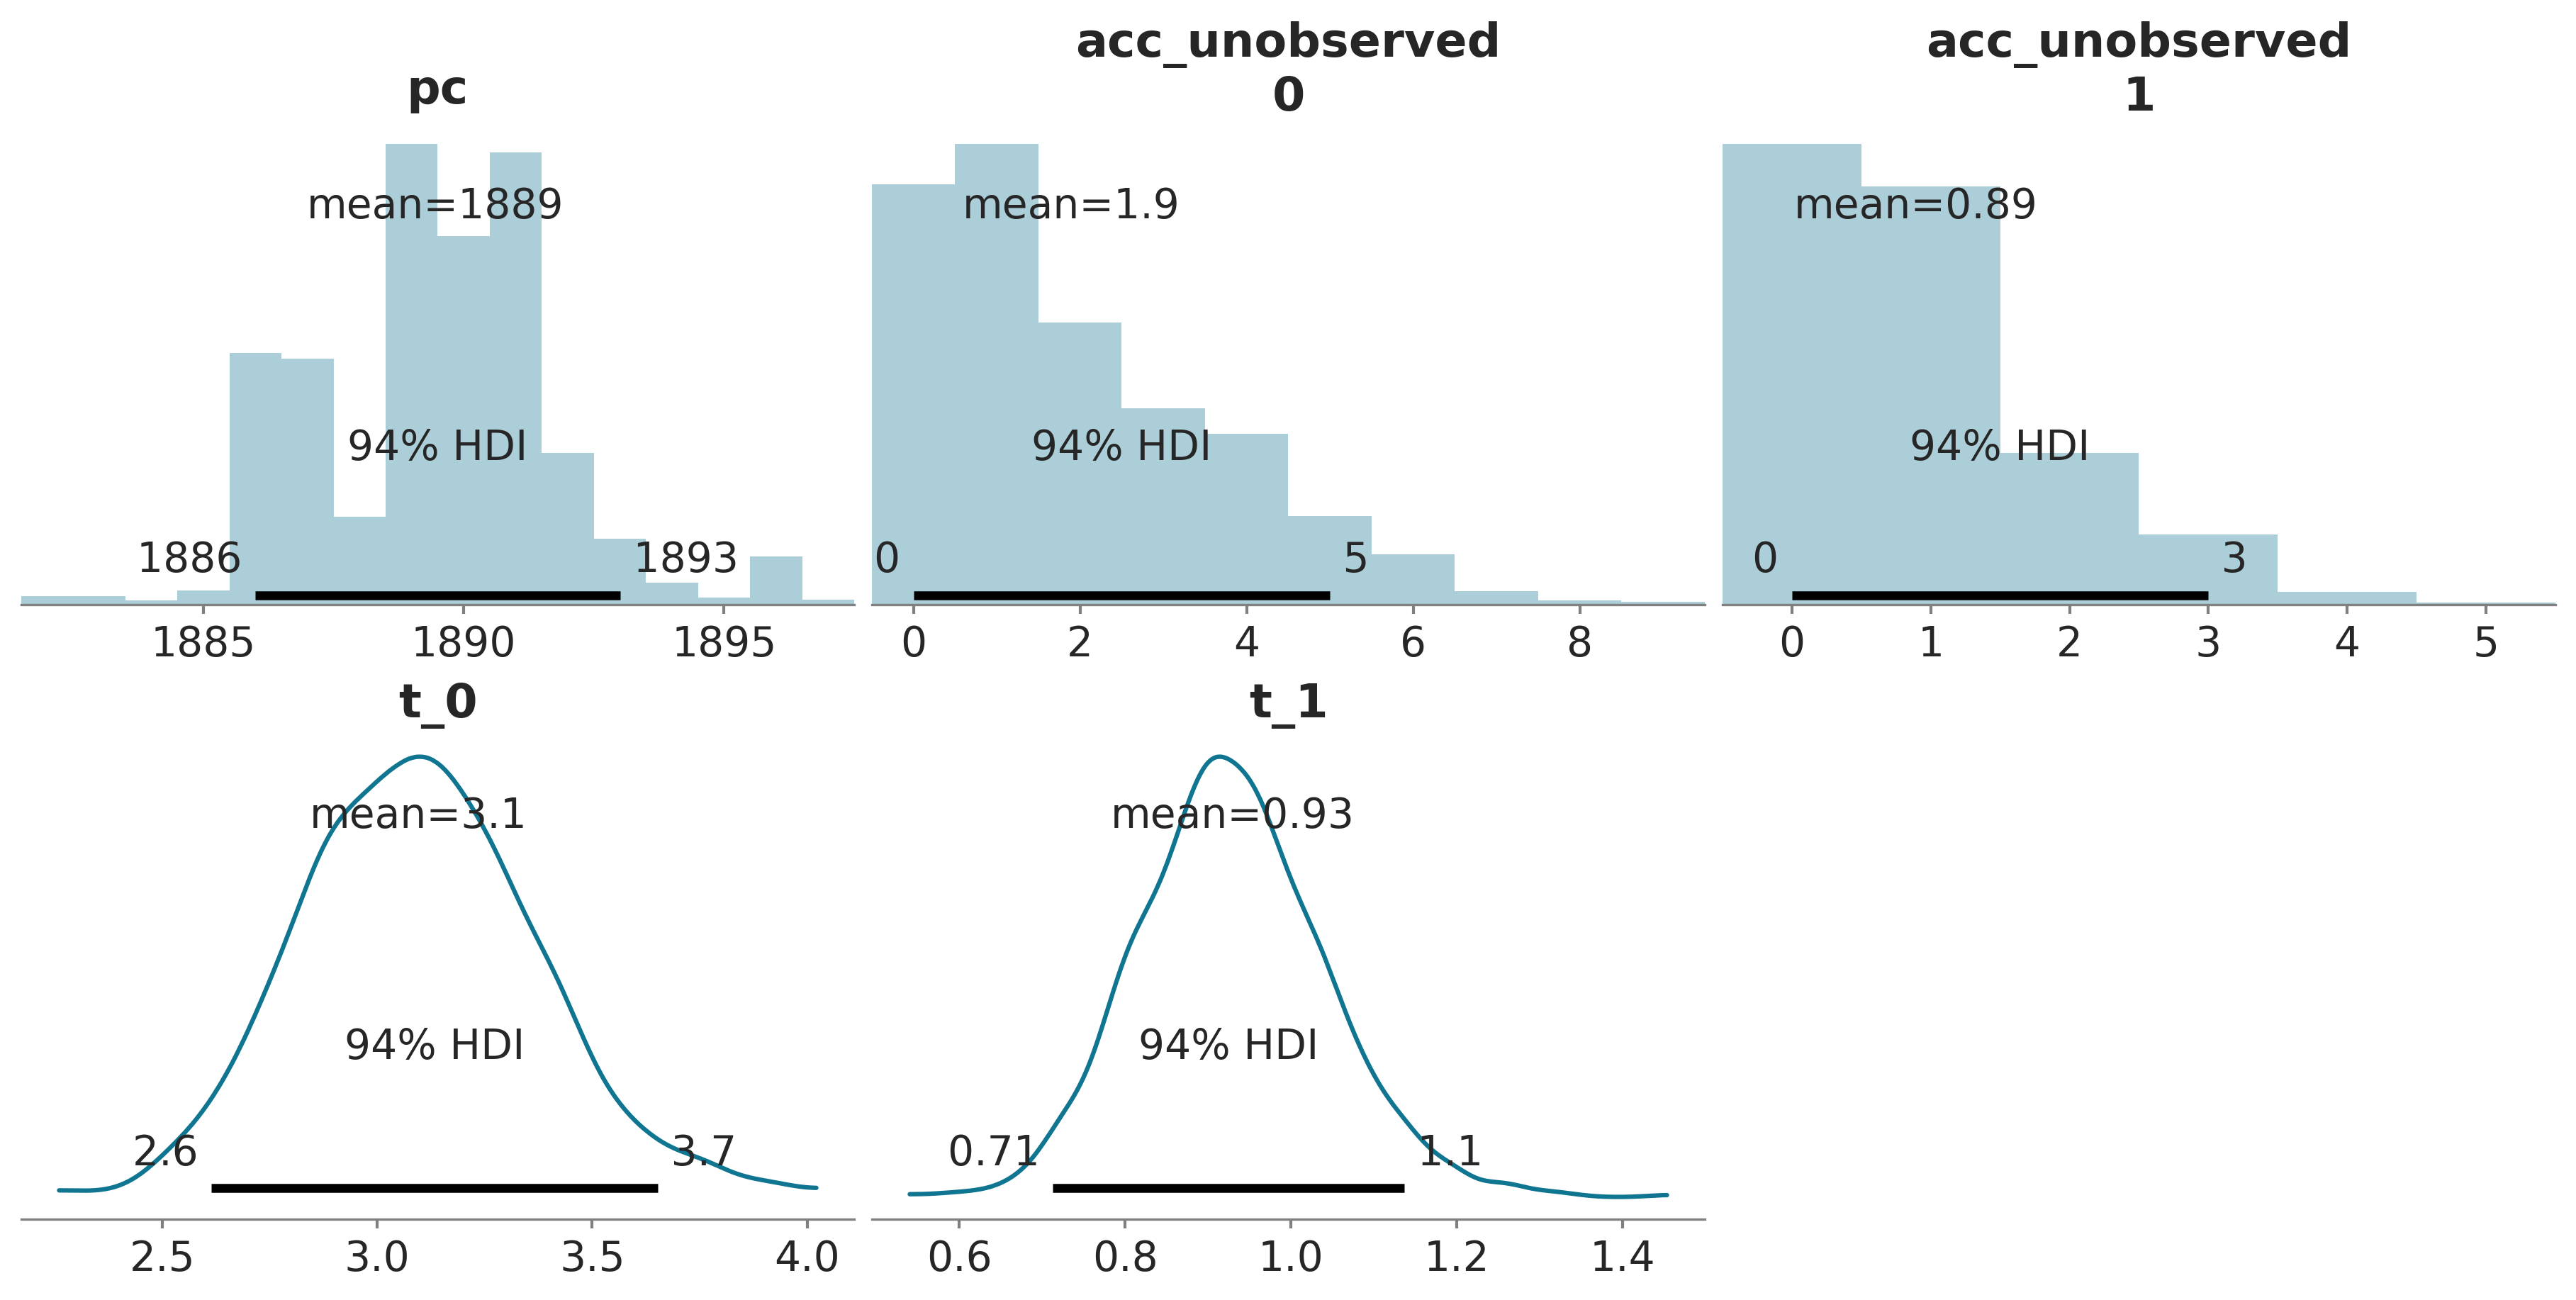

In [37]:
ax = az.plot_posterior(idata_cat, var_names=["~tasa", "~acc"], figsize=(12, 6));

In [38]:
az.summary(idata_cat, var_names=["~tasa", "~acc"])

mean     sd    hdi_3%   hdi_97%  mcse_mean  mcse_sd  \
pc                 1889.456  2.346  1886.000  1893.000      0.190    0.135   
acc_unobserved[0]     1.895  1.766     0.000     5.000      0.139    0.099   
acc_unobserved[1]     0.892  0.962     0.000     3.000      0.048    0.037   
t_0                   3.096  0.275     2.614     3.652      0.007    0.005   
t_1                   0.929  0.114     0.713     1.136      0.003    0.002   

                   ess_bulk  ess_tail  r_hat  
pc                    149.0     254.0   1.02  
acc_unobserved[0]     154.0     193.0   1.02  
acc_unobserved[1]     408.0     419.0   1.00  
t_0                  1346.0    1222.0   1.00  
t_1                  1566.0    1349.0   1.00

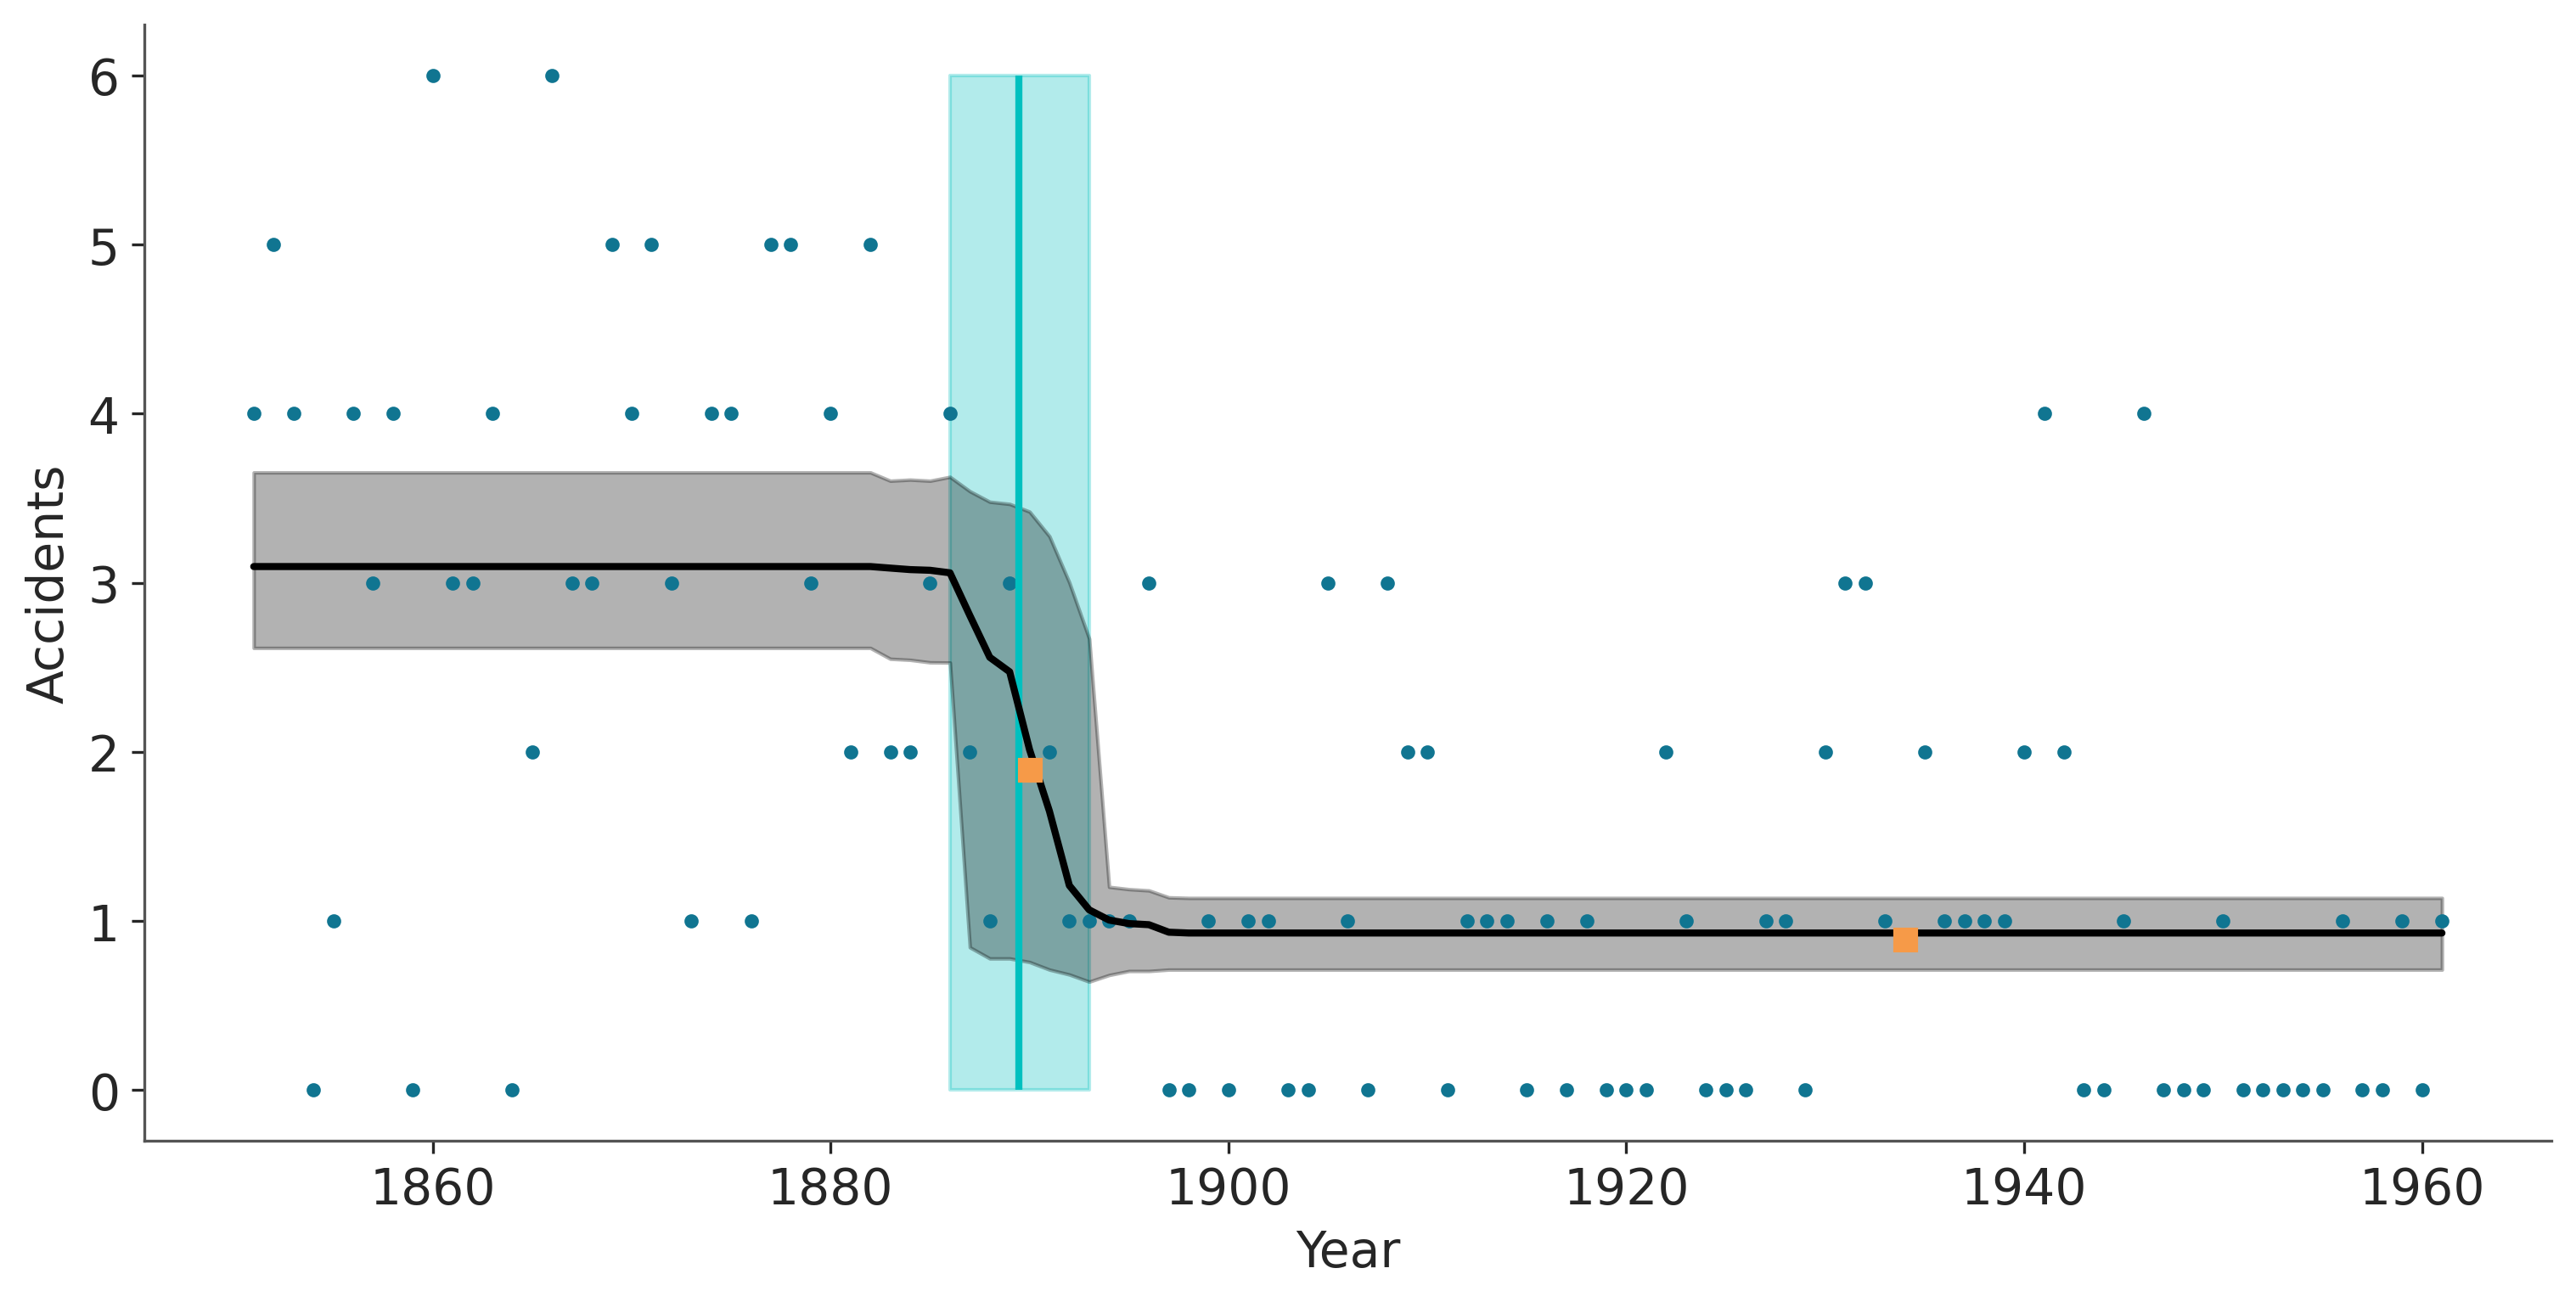

In [42]:
tasa_mean = idata_cat.posterior["tasa"].mean(("chain", "draw"))
tasa_hdi = az.hdi(idata_cat.posterior["tasa"].values)
pc_hdi = az.hdi(idata_cat.posterior["pc"])["pc"]

_, ax = plt.subplots(figsize=(10, 5), sharey=True)
ax.plot(years, data, ".")

ax.set_ylabel("Accidents")
ax.set_xlabel("Year")

ax.vlines(
    idata_cat.posterior["pc"].mean(("chain", "draw")),
    data.min(),
    data.max(),
    color="C1",
    lw=2,
)


ax.fill_betweenx(
    [data.min(), data.max()], pc_hdi[0], pc_hdi[1], alpha=0.3, color="C1"
)
ax.plot(years, tasa_mean, "k", lw=2)
ax.fill_between(years, tasa_hdi[:, 0], tasa_hdi[:, 1], alpha=0.3, color="k")

faltante0 = (
    idata_cat.posterior["acc_unobserved"].sel(acc_unobserved_dim_0=0).mean(("chain", "draw"))
)
faltante1 = (
    idata_cat.posterior["acc_unobserved"].sel(acc_unobserved_dim_0=1).mean(("chain", "draw"))
)

ax.plot(years[np.isnan(data)], [faltante0, faltante1], "C2s");

## Post Hoc Predictive Test
- Comparing predicted data with the observed data
- Self consistency tests
- plot_ppc:
  - Represents the observed data, several samples from the posterior predictive and the mean
  - If the data is continuous then KDE
  - If the data is discrete then histograms
- plot_loo_pit:
  - Difference between observed and predicted data(blue line), such that if there were no difference we would obtain an uniform distribution (white line)
  - xaxis: Quantiles 
  - If the curve is above blue line: More observations than predictions
  - Below is the opposite
  - Band
    - Expected deviations from the uniform distribution given the sample size
    - Any difference between the band is "expected"

In [44]:
idata_cat.extend(
    pm.sample_posterior_predictive(idata_cat, model=model, random_seed=1791)
)

c:\Users\Gabriel\mambaforge\envs\bayes\lib\site-packages\pymc\pytensorf.py:1055: UserWarning: RNG Variable RandomGeneratorSharedVariable(<Generator(PCG64) at 0x23CB6802F80>) has multiple clients. This is likely an inconsistent random graph.
  warnings.warn(
Sampling: [acc_observed]


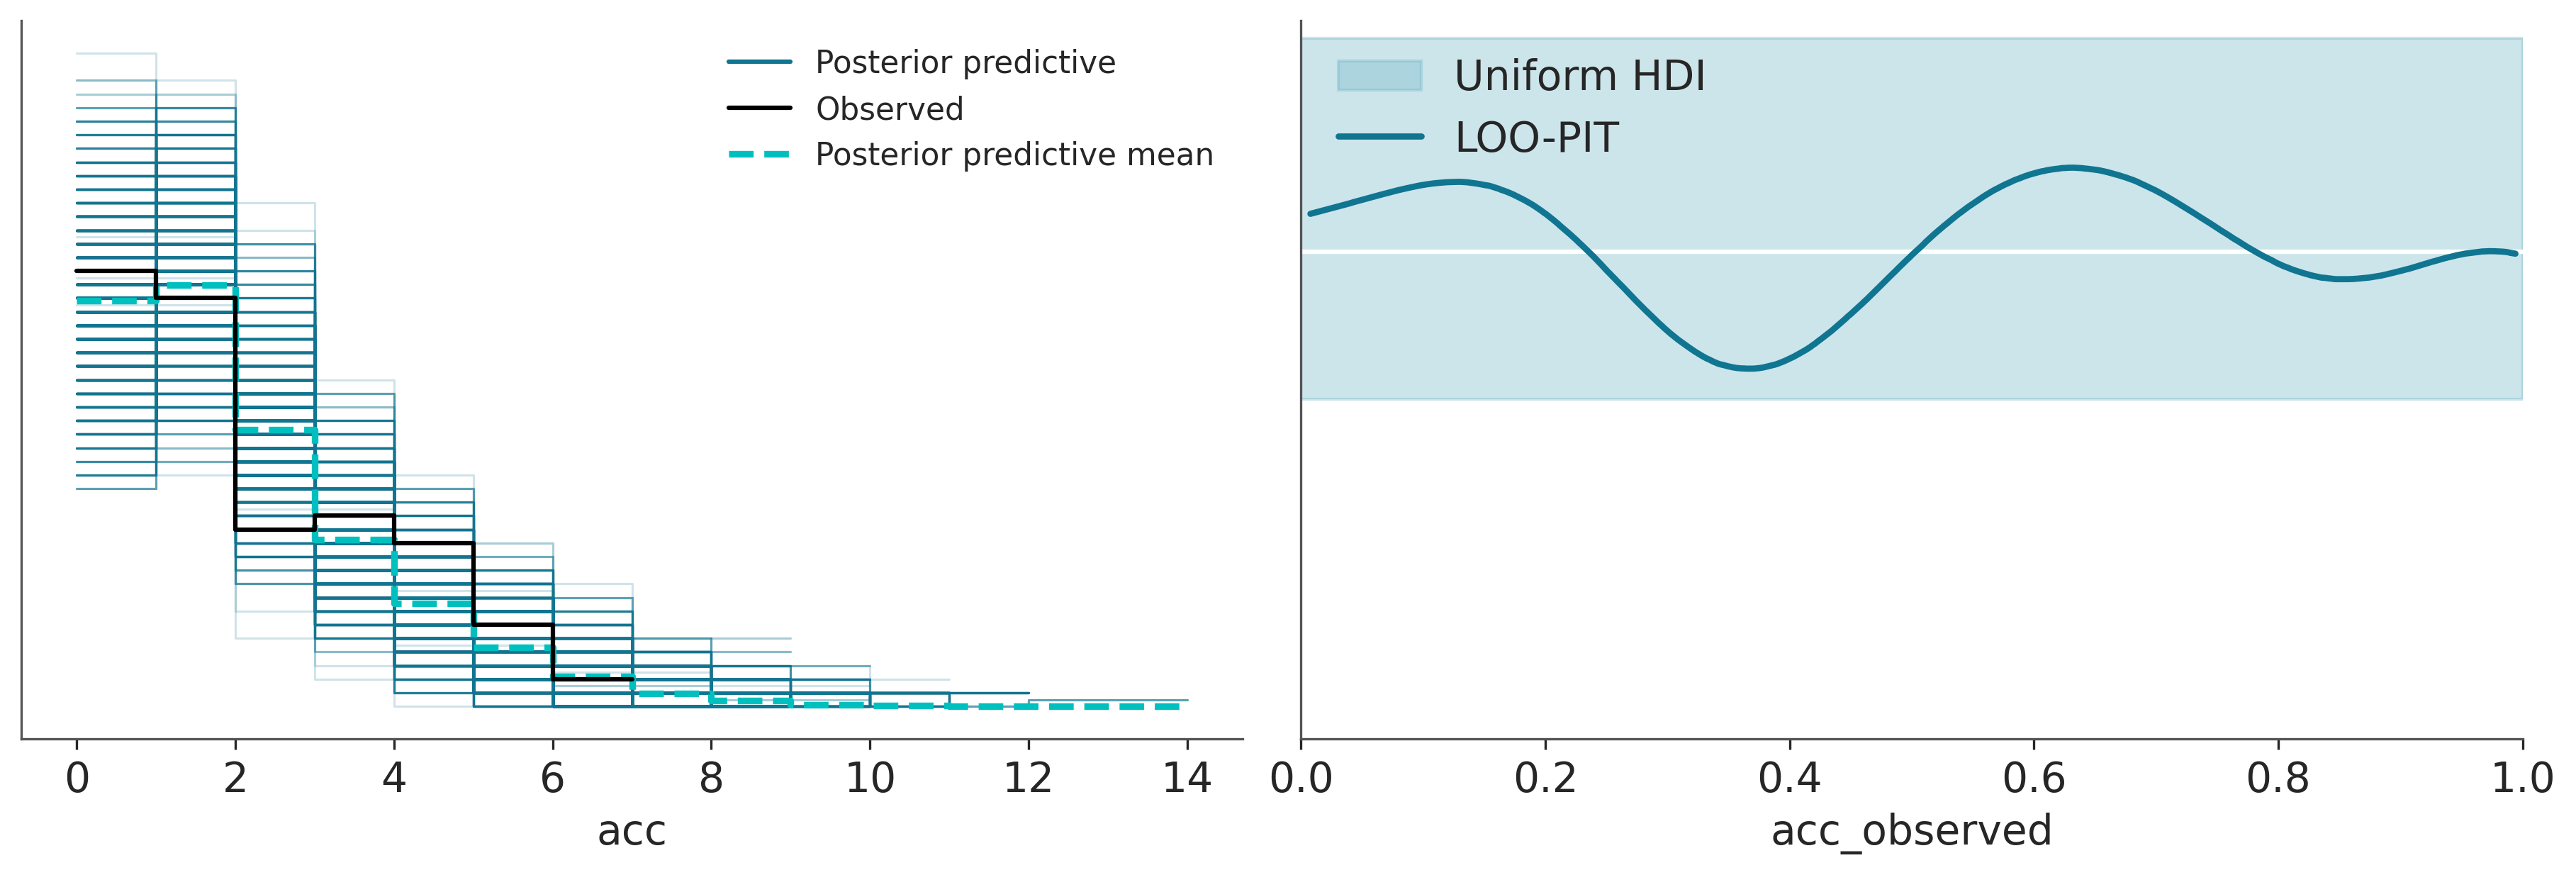

In [45]:
_, ax = plt.subplots(1, 2, figsize=(12, 4))
az.plot_ppc(idata_cat, ax=ax[0])
ax[0].set_xlabel("acc")
az.plot_loo_pit(idata_cat, "acc_observed", ax=ax[1], use_hdi=True)
ax[1].set_yticks([]);

## Predictive Tests a priori
- The data that the model expects to see
- Tests of consistency with our prior knowledge

In [46]:
idata_cat.extend(pm.sample_prior_predictive(model=model, random_seed=1791))

c:\Users\Gabriel\mambaforge\envs\bayes\lib\site-packages\pymc\pytensorf.py:1055: UserWarning: RNG Variable RandomGeneratorSharedVariable(<Generator(PCG64) at 0x23CB6802F80>) has multiple clients. This is likely an inconsistent random graph.
  warnings.warn(
Sampling: [acc_observed, acc_unobserved, pc, t_0, t_1]


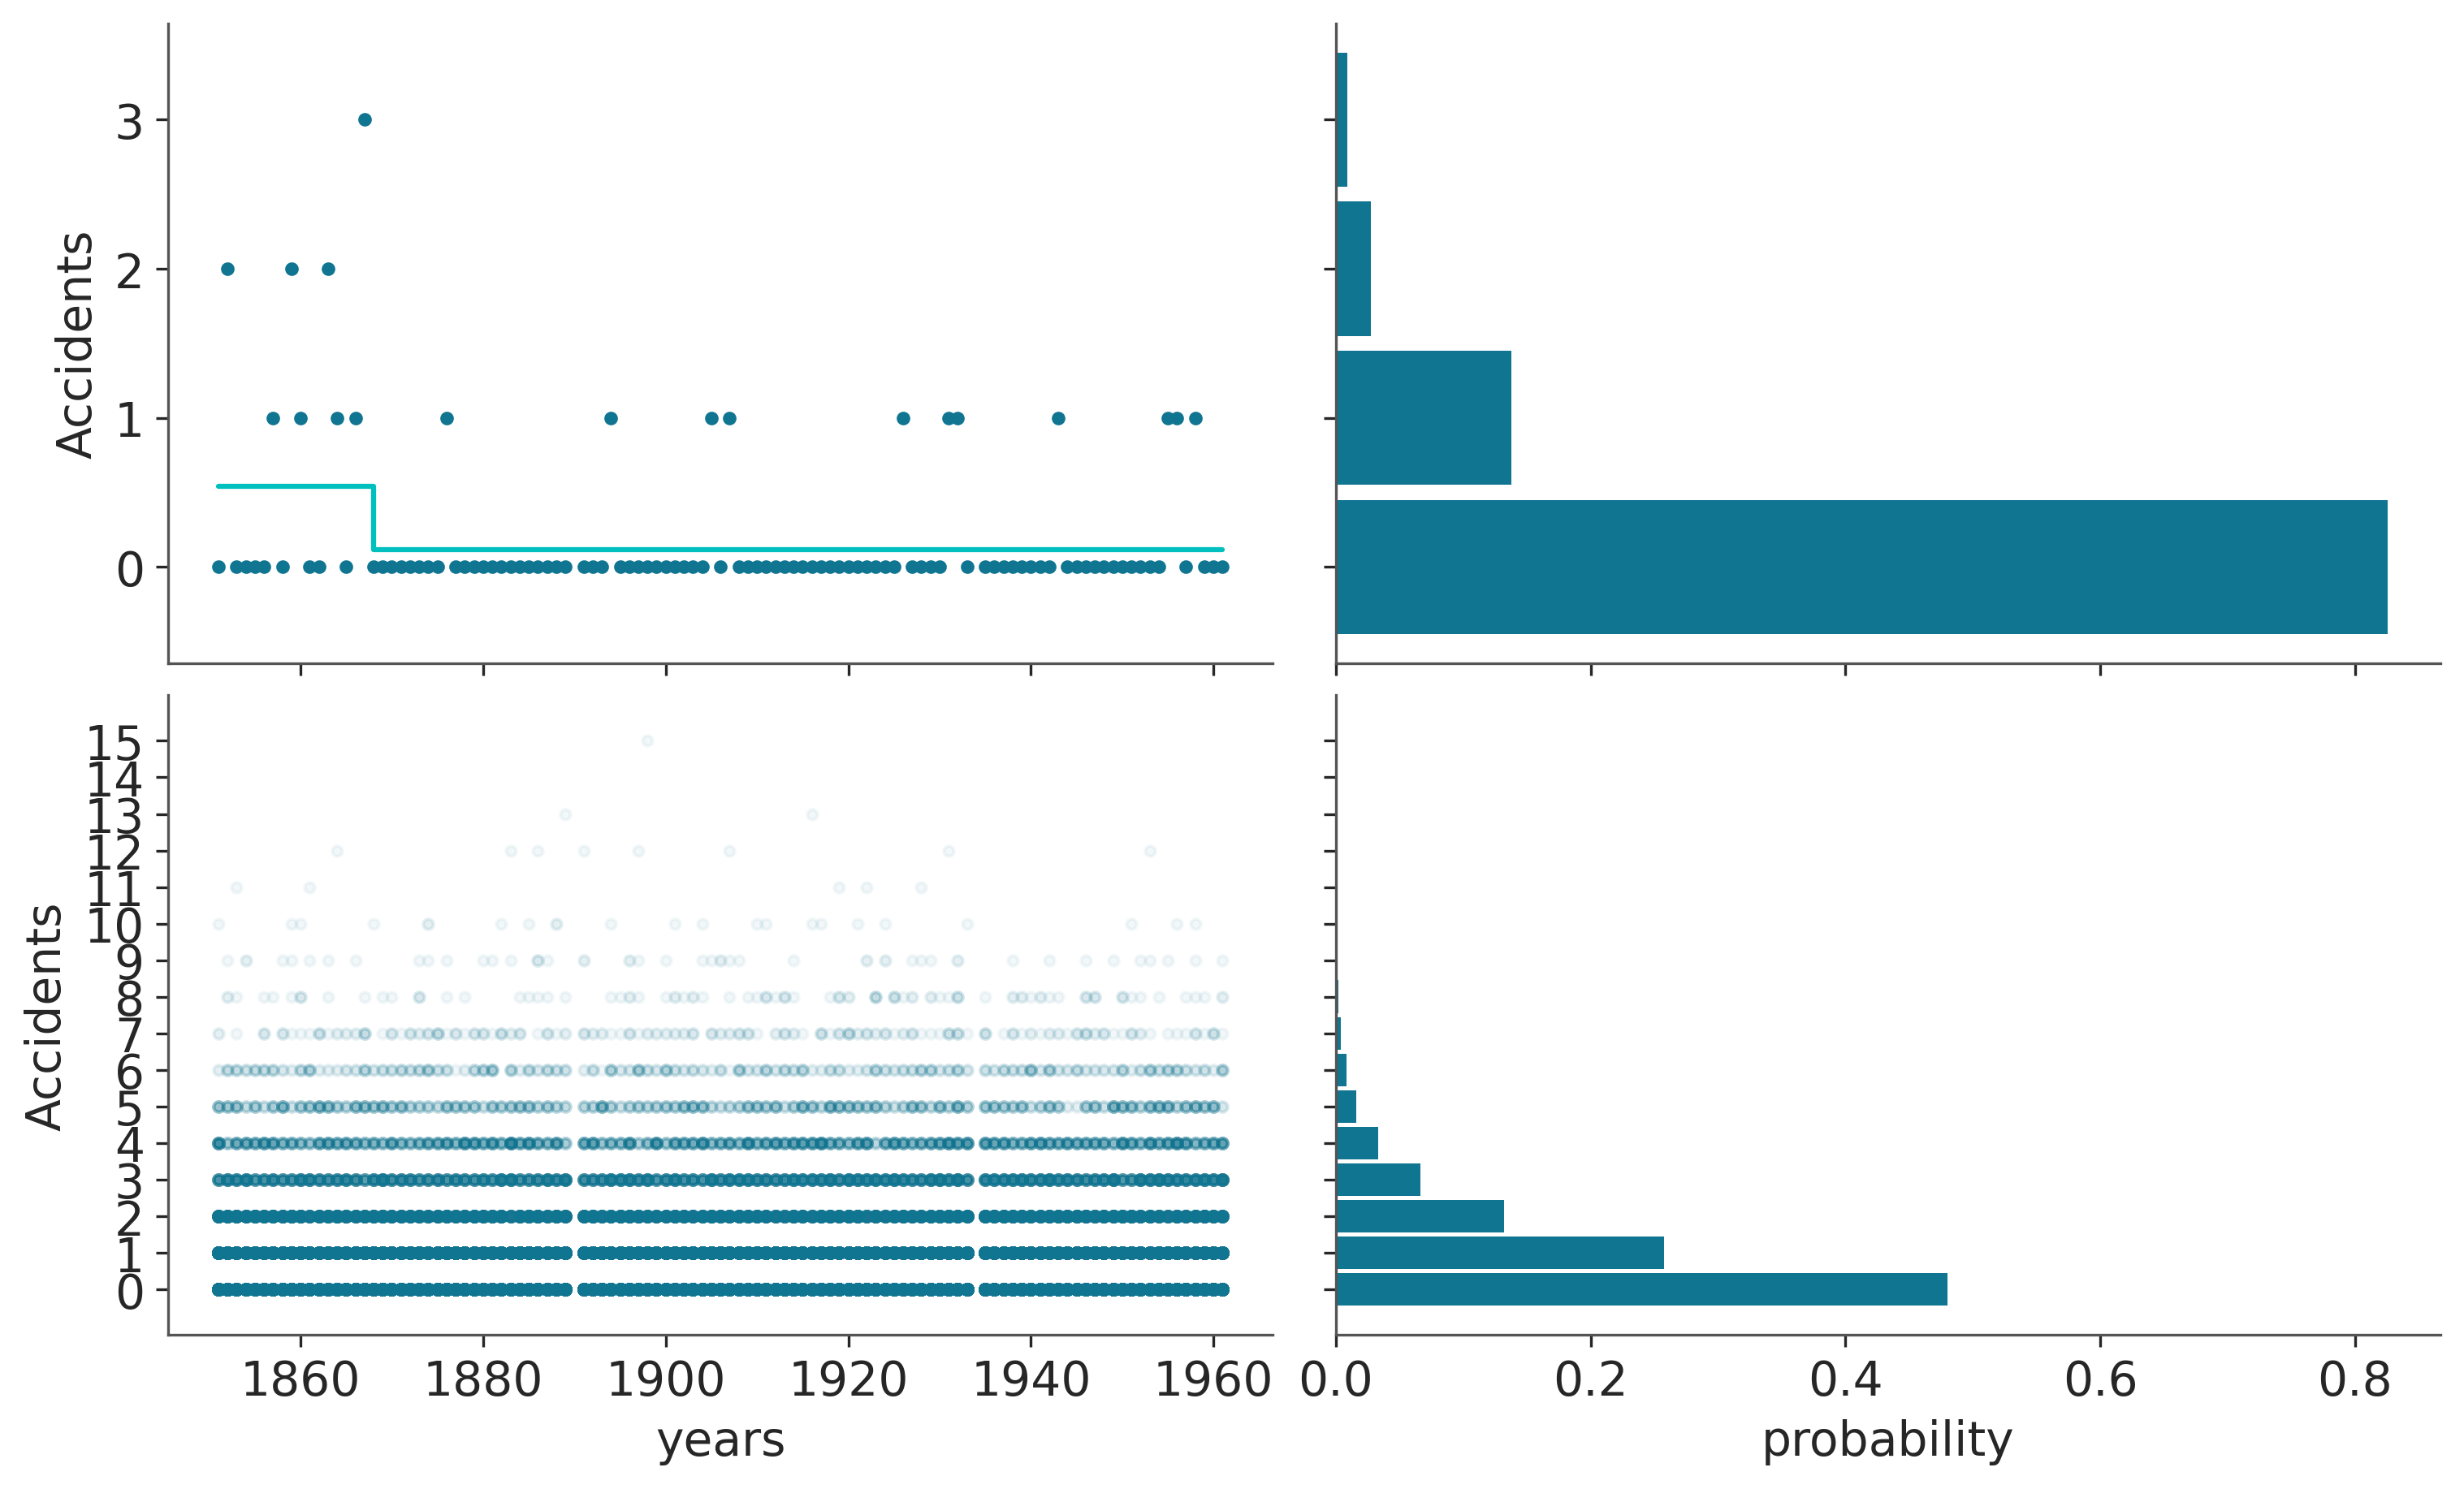

In [48]:
_, ax = plt.subplots(2, 2, figsize=(10, 6), sharey="row", sharex="col")

ax[0, 0].plot(
    years[np.isfinite(data)],
    idata_cat.prior_predictive["acc_observed"].sel(draw=50).squeeze("chain").T,
    ".",
)
a_sample = idata_cat.prior.sel(draw=50)
coco = np.full_like(years, a_sample["t_1"].item(), dtype=float)
coco[a_sample["pc"] >= years] = a_sample["t_0"].item()
ax[0, 0].step(years, coco)
ax[0, 0].set_ylabel("Accidents")

az.plot_dist(
    idata_cat.prior_predictive["acc_observed"].sel(draw=50), ax=ax[0, 1], rotated=True
)


ax[1, 0].plot(
    years[np.isfinite(data)],
    idata_cat.prior_predictive["acc_observed"].squeeze("chain").T,
    "C0.",
    alpha=0.05,
)
ax[1, 0].set_ylabel("Accidents")
ax[1, 0].set_xlabel("years")

az.plot_dist(idata_cat.prior_predictive["acc_observed"], ax=ax[1, 1], rotated=True)
ax[1, 1].set_xlabel("probability");

## Comparing Groups
- Common characteristic is the difference between means
- We can calculate the posterior distribution of the difference between means
- Three tols
  - Posterior plot with reference value
  - Cohen's d
  - Probability of superiority
- Cohen's d
  - $$\frac{\mu_{2} - \mu_{1}}{\sqrt\frac{\sigma_{2}^2 + \sigma_{1}^2}{2}}$$
  - Can be interpreted as a z-score
- Probability of superiority
  - Probability that a point taken at random from one group has a higher value than a point taken from other group. If we assume that the data used is normally distributed
    - $$ps=\Phi(\frac{\delta}{\sqrt{2}})$$
    - $\delta$: Cohen's d
    - $\Phi$: Cumulative normal distribution

### Example: Tips dataset

In [50]:
tips = pd.read_csv("data/propinas.csv")
tips.tail()

total_bill   tip     sex smoker   day    time  size
239       29.03  5.92    Male     No   Sat  Dinner     3
240       27.18  2.00  Female    Yes   Sat  Dinner     2
241       22.67  2.00    Male    Yes   Sat  Dinner     2
242       17.82  1.75    Male     No   Sat  Dinner     2
243       18.78  3.00  Female     No  Thur  Dinner     2

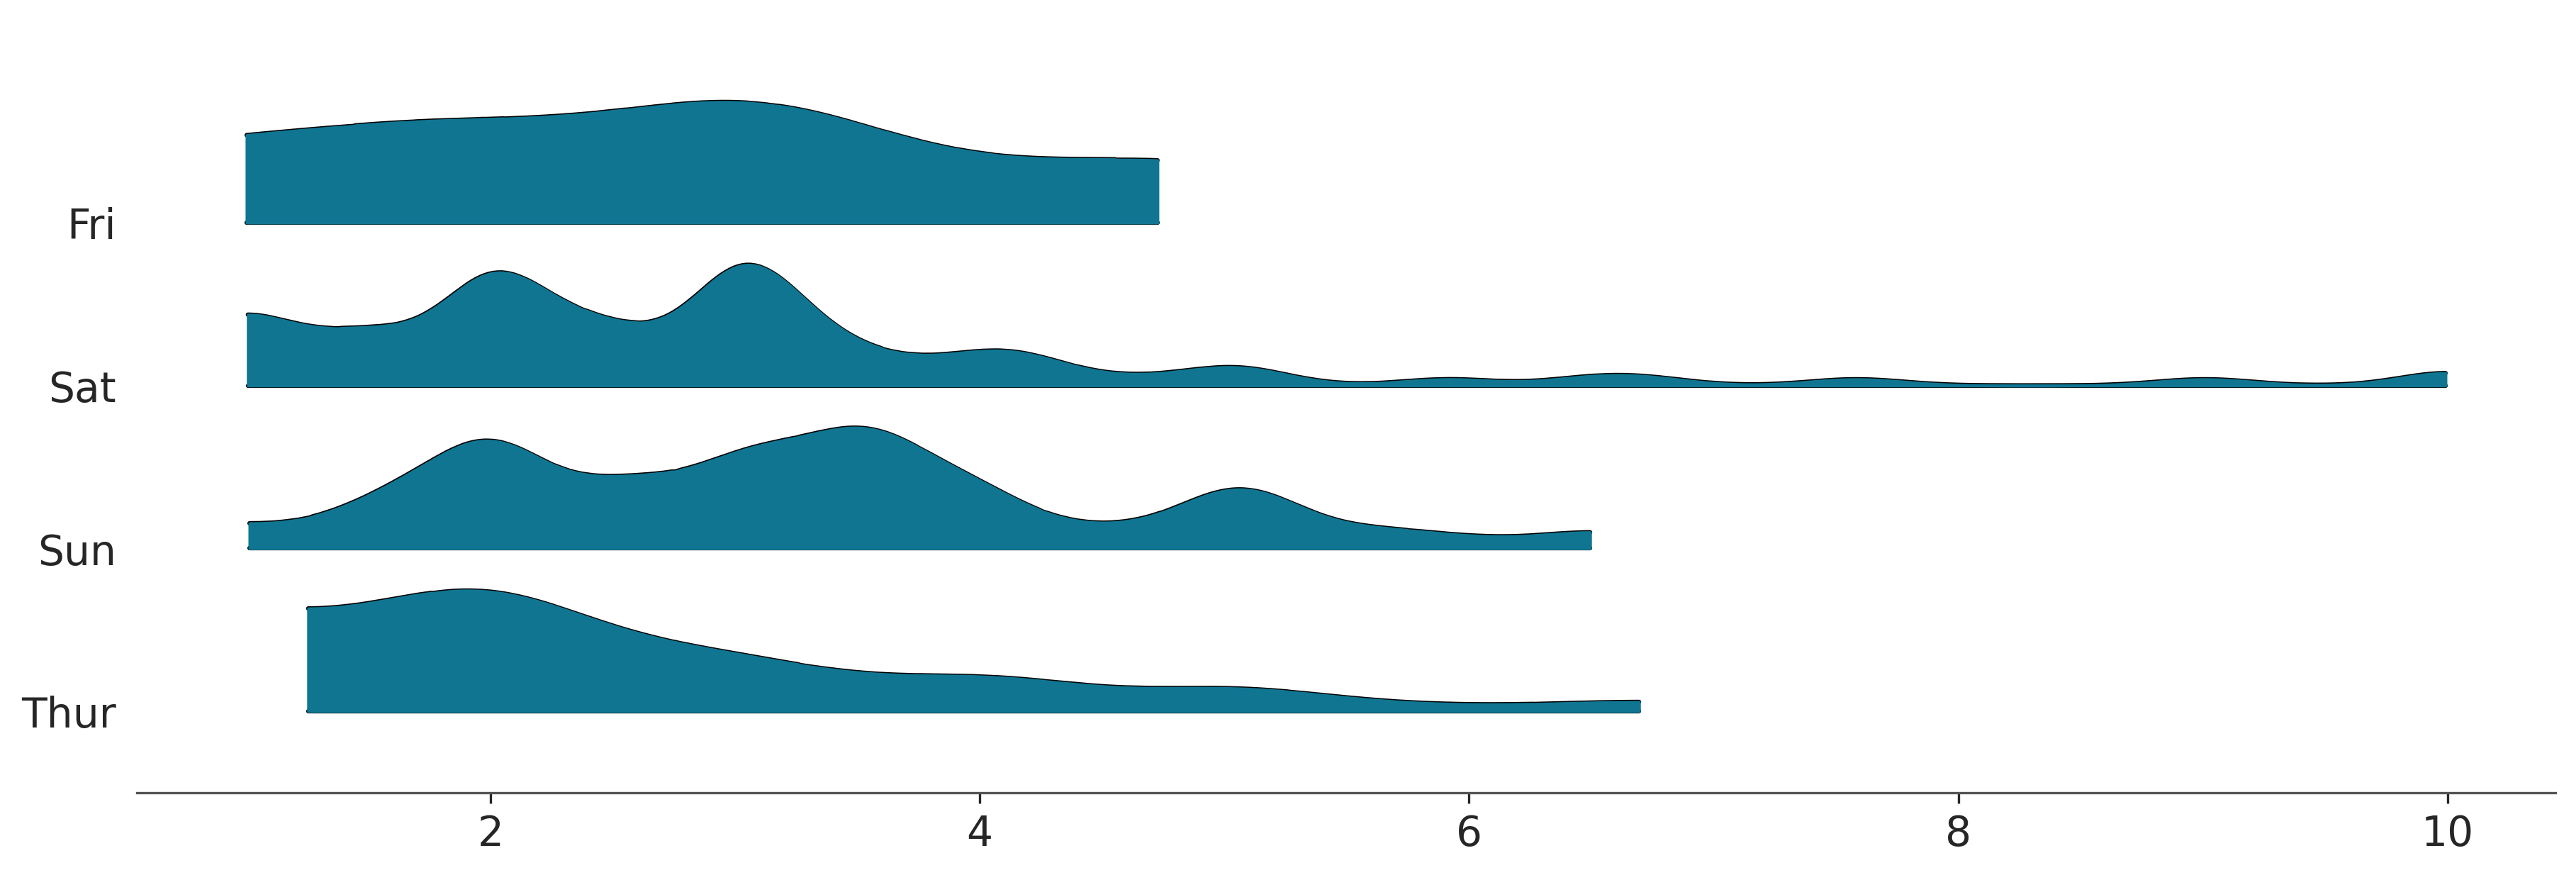

In [51]:
az.plot_forest(
    tips.pivot(columns="day", values="tip").to_dict("list"),
    kind="ridgeplot",
    hdi_prob=1,
    figsize=(12, 4),
);

In [53]:
categories = np.array(["Thur", "Fri", "Sat", "Sun"])
tip = tips["tip"].values
idx = pd.Categorical(tips["day"], categories=categories).codes
categories,idx

(array(['Thur', 'Fri', 'Sat', 'Sun'], dtype='<U4'),
 array([3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 2, 2, 2,
        2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3, 3, 3,
        3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
        2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2,
        2, 2, 3, 3, 3, 3, 3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 3, 3, 3, 3,
        3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 2, 2, 2, 2, 3, 3, 3, 3,
        3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
        1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
        2, 0], dtype=int8))

In [54]:
with pm.Model() as comparing_groups:
    μ = pm.Normal('μ', mu=0, sigma=10, shape=4) # Vector of size 4
    σ = pm.HalfNormal('σ', sigma=10, shape=4) # Vector of size 4

    y = pm.Normal('y', mu=μ[idx], sigma=σ[idx], observed=tip) # Index appropriately the mean and std to the correct groups

In [55]:
coords = {"days": categories, "days_flat": categories[idx]}

with pm.Model(coords=coords) as comparing_groups:
    μ = pm.HalfNormal("μ", sigma=5, dims="days")
    σ = pm.HalfNormal("σ", sigma=1, dims="days")

    y = pm.Gamma("y", mu=μ[idx], sigma=σ[idx], observed=tip, dims="days_flat")

    idata_cg = pm.sample()
    idata_cg.extend(pm.sample_posterior_predictive(idata_cg))

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [μ, σ]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 32 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics
Sampling: [y]


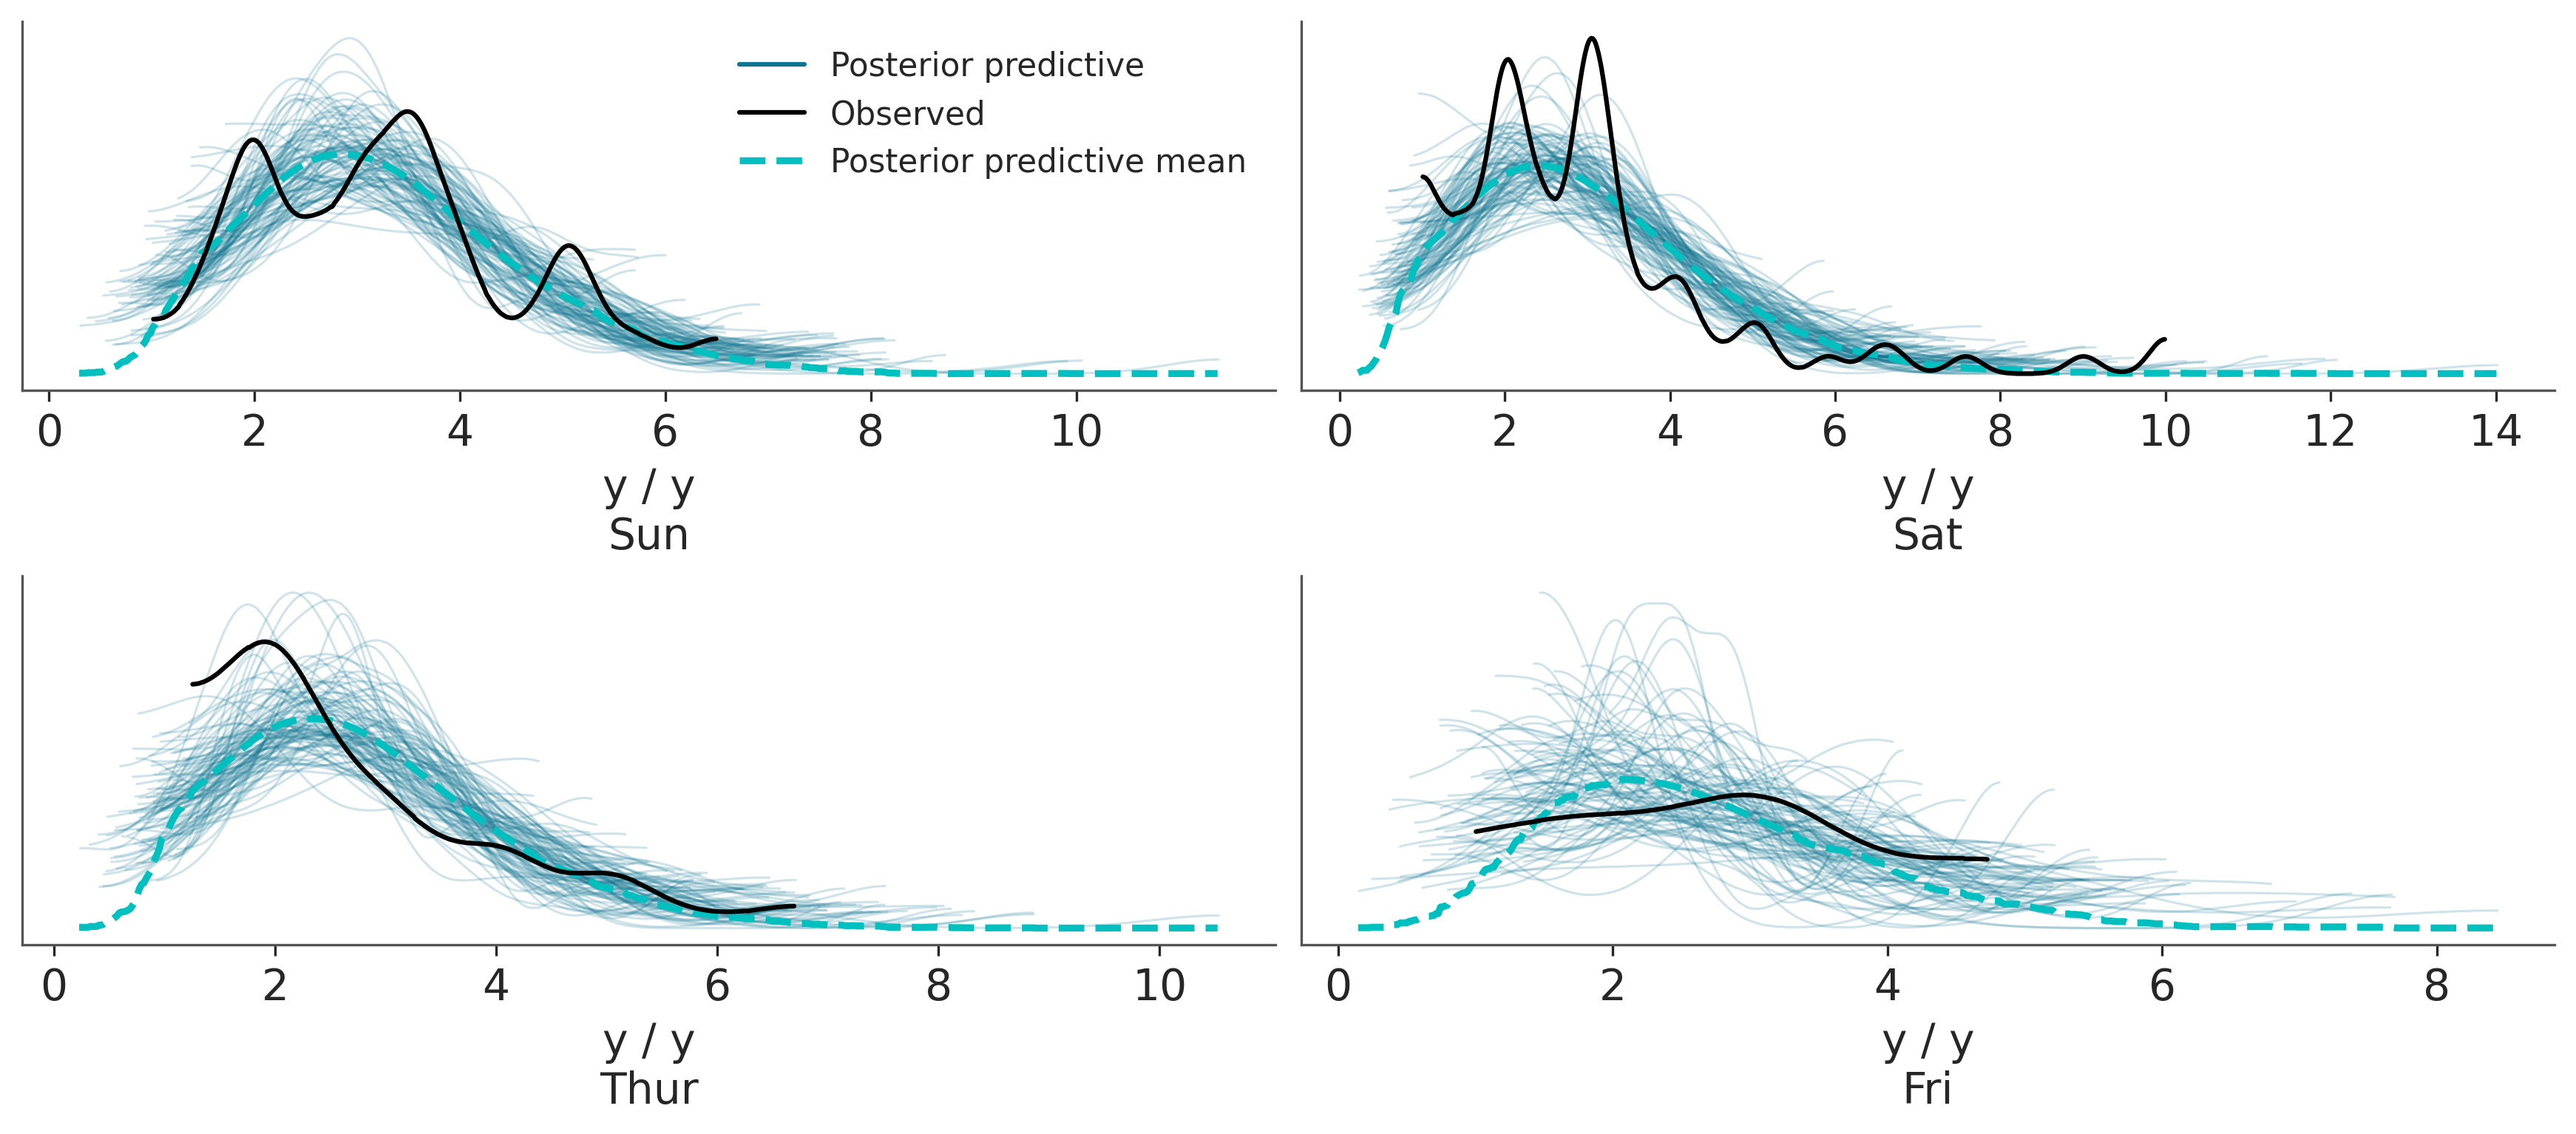

In [56]:
_, axes = plt.subplots(2, 2)
az.plot_ppc(
    idata_cg,
    num_pp_samples=100,
    coords={"days_flat": [categories]},
    flatten=[],
    ax=axes,
);

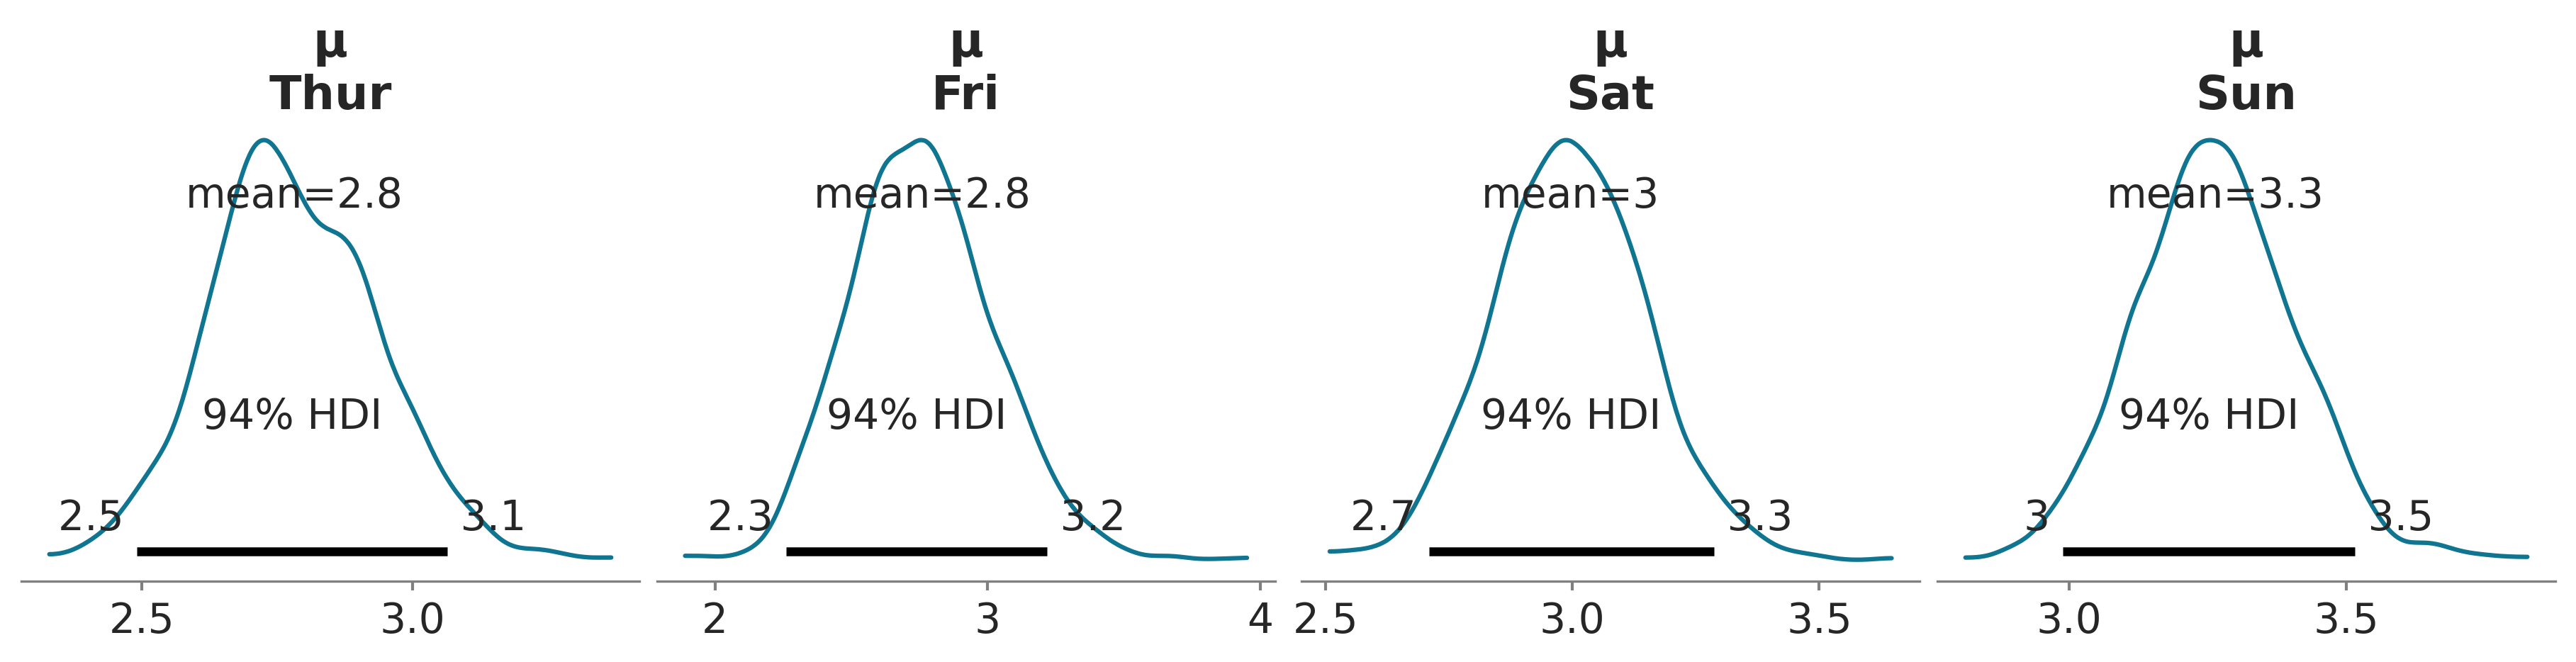

In [57]:
az.plot_posterior(idata_cg, var_names="μ", figsize=(12, 3));

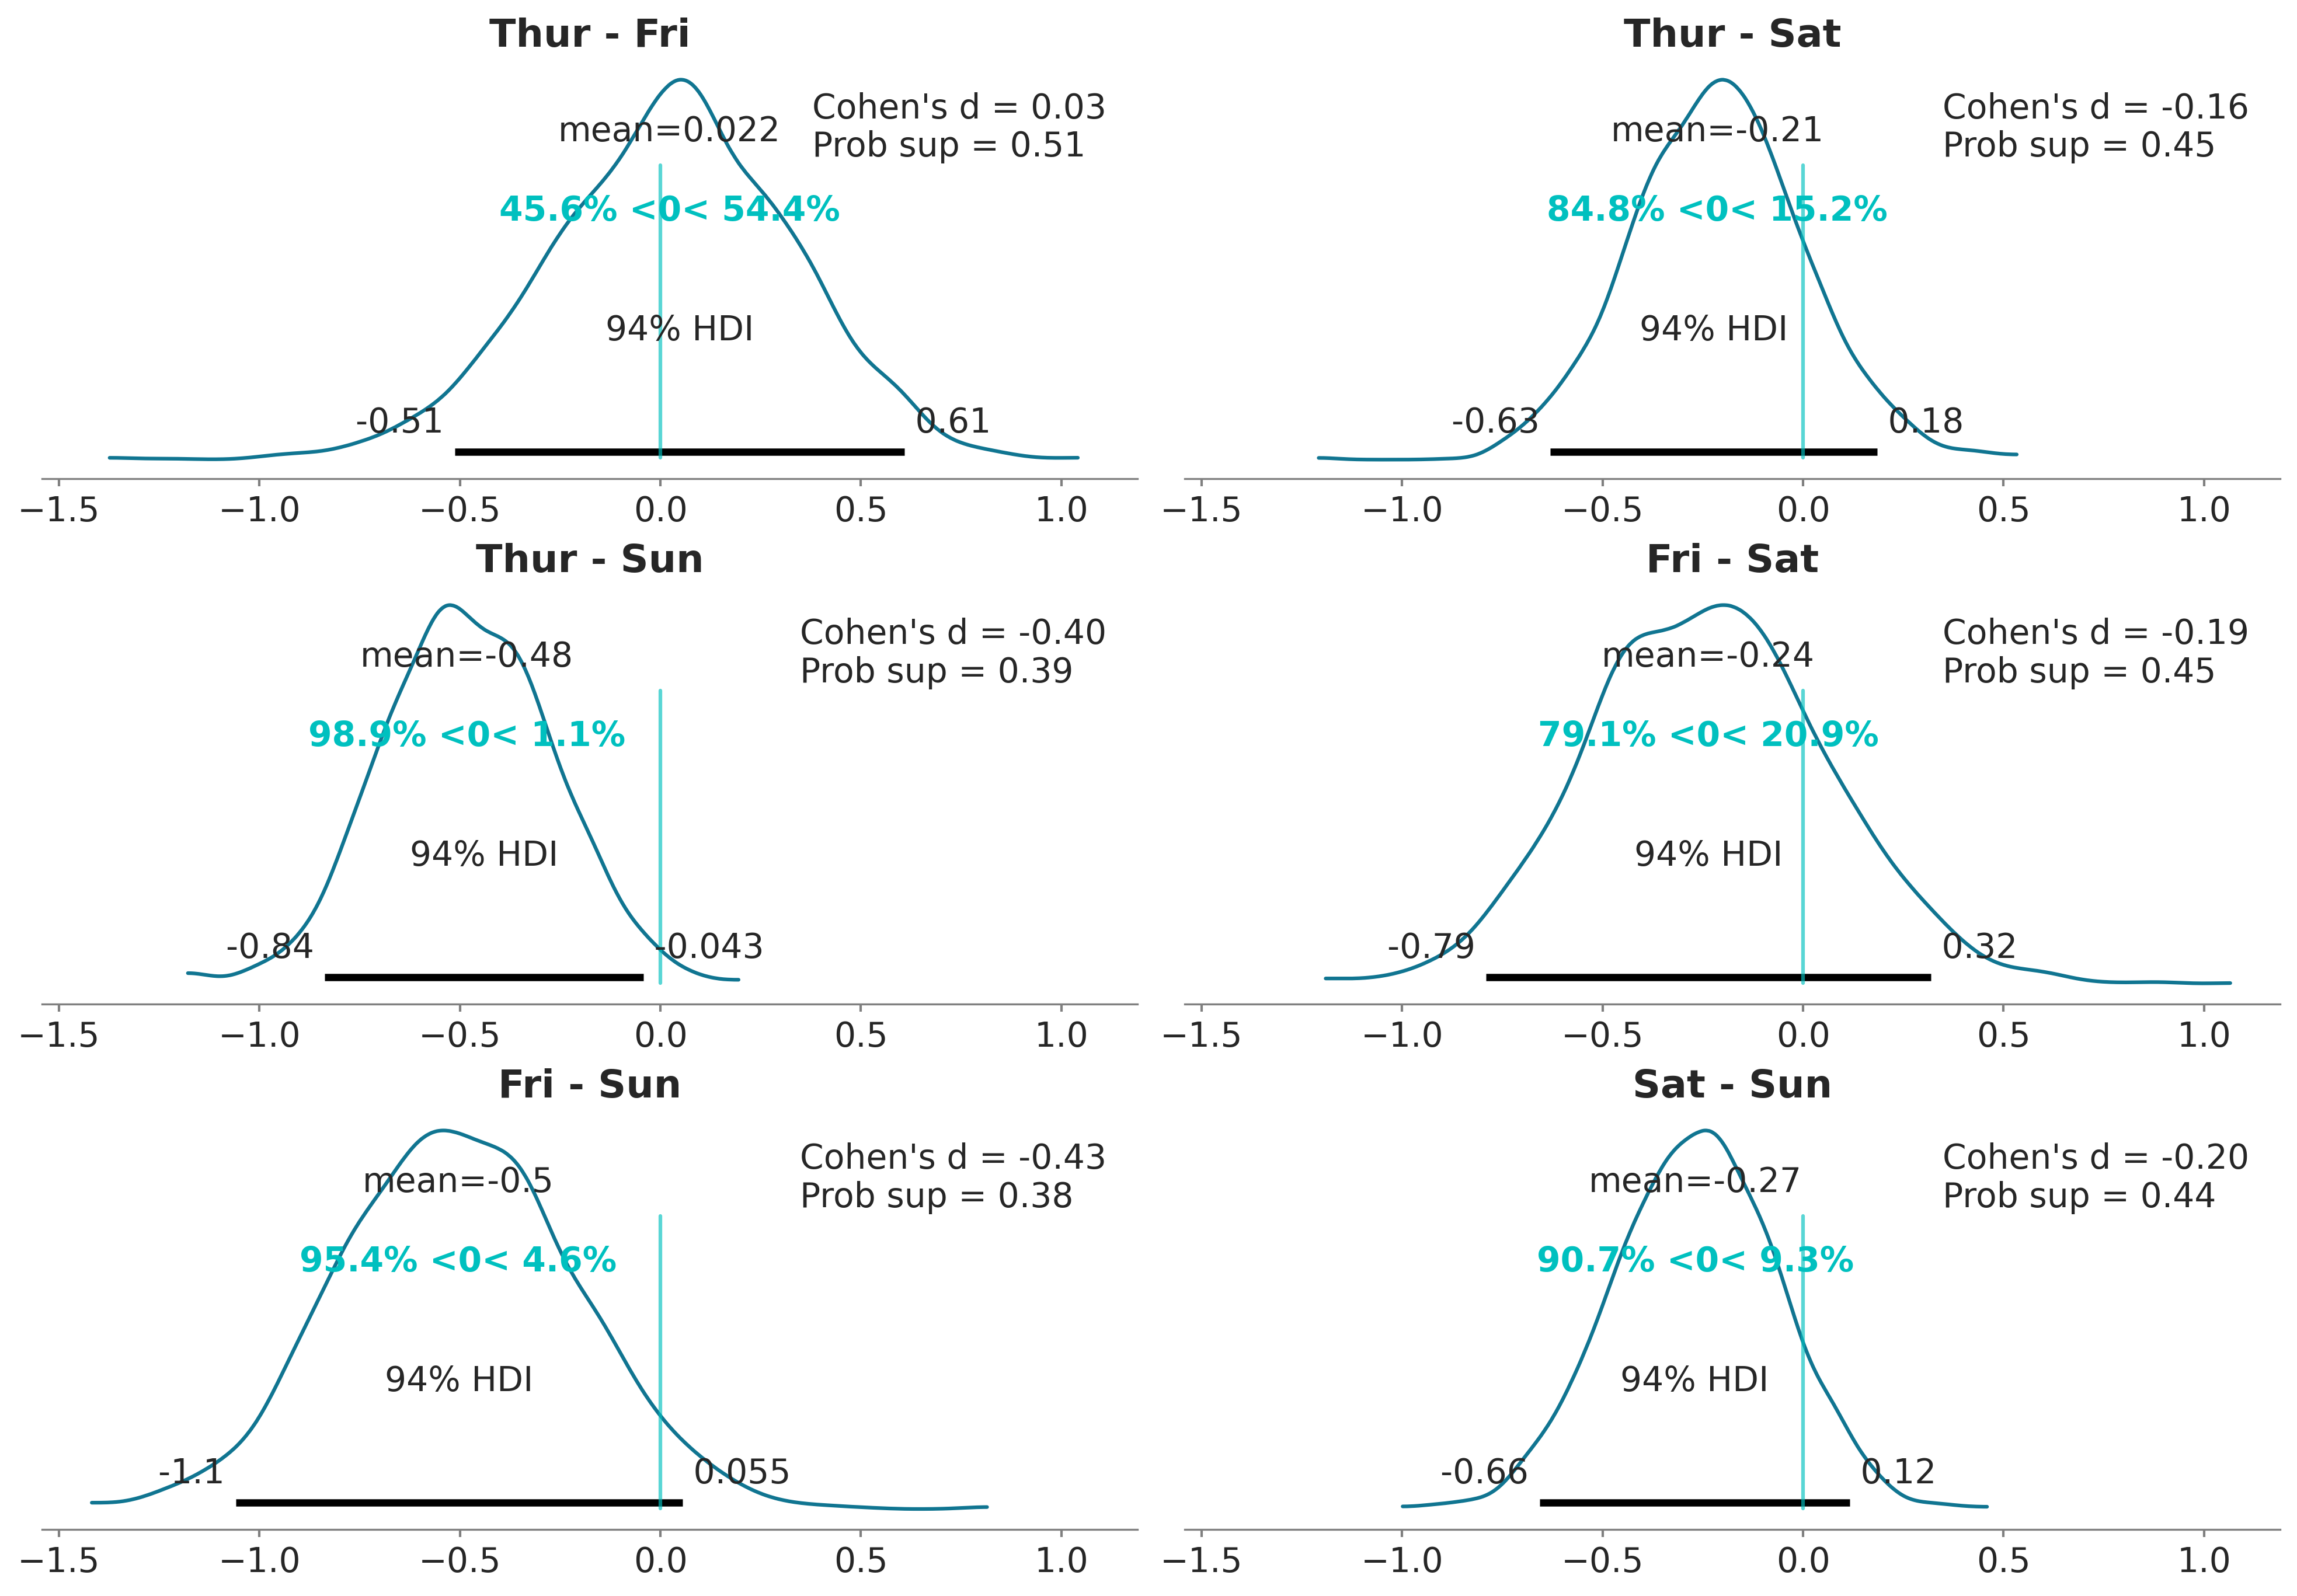

In [58]:
cg_posterior = az.extract(idata_cg)

dist = pz.Normal(0, 1)

comparisons = [(categories[i], categories[j]) for i in range(4) for j in range(i+1, 4)]

_, axes = plt.subplots(3, 2, figsize=(13, 9), sharex=True)

for (i, j), ax in zip(comparisons, axes.ravel()):
    means_diff = cg_posterior["μ"].sel(days=i) - cg_posterior['μ'].sel(days=j)
    
    d_cohen = (means_diff /
               np.sqrt((cg_posterior["σ"].sel(days=i)**2 + 
                        cg_posterior["σ"].sel(days=j)**2) / 2)
              ).mean().item()
    
    ps = dist.cdf(d_cohen/(2**0.5))
    az.plot_posterior(means_diff.values, ref_val=0, ax=ax)
    ax.set_title(f"{i} - {j}")
    ax.plot(0, label=f"Cohen's d = {d_cohen:.2f}\nProb sup = {ps:.2f}", alpha=0)
    ax.legend(loc=1)